In [1]:
import pathlib

import yaml

import numpy as np

import itertools

In [2]:
from pixell import enmap, utils as putils

In [3]:
import utilities as u

In [4]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'Latin Modern Roman'}
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 8)


In [5]:
import best
import re

In [6]:
paperplots = pathlib.Path('paperplots')

### Some general settings

In [360]:
values_file = 'config.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [361]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [362]:
C = u.Converting()

In [363]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [364]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [365]:
colors_ests['kk'] = 'black'
colors_ests['kg'] = 'yellow'

labels_ests['kk'] = 'Signal'
labels_ests['kg'] = 'Cross signal'

In [366]:
PP

PosixPath('output')

## Plot noises for lmax = 3500 vs signal

In [376]:
lmax_fixed = 3500

In [377]:
fsky = 1.

In [378]:
changemap = lambda x: enmap.enmap(x, wcs)
mapsObjA = u.mapNamesObj(nu)
LoadA = u.LoadfftedMaps(mapsObj = mapsObjA, WR = WR, ConvertingObj = C, changemap = changemap, getfft = u.fft)

In [379]:
shape = LoadA.read_shape()
lonCenter, latCenter = 0, 0
shape, wcs = enmap.geometry(shape = shape, res = 1.*putils.arcmin, pos = (lonCenter, latCenter))
modlmap = enmap.modlmap(shape, wcs)
field_names_A = ['A1', 'A2']
feed_dict = u.Loadfeed_dict(spectra_path, field_names_A, field_names_A, modlmap)

/gpfs/fs0/scratch/r/rbond/omard/CORI17112020/qelensingcomb/utilities.py:353: RuntimeWarning: divide by zero encountered in log
  logTT = np.log(ctt)


In [17]:
lmin_A, lmax_A = 30, 3500
Lmin, Lmax = 20, 6000

In [18]:
Binner = u.Binner(shape, wcs, lmin = 10, lmax = 6000, deltal = 30, log = False, nBins = 20)

In [19]:
lmaxes = lmaxes_configs[0] 
lmaxes_dict = {}
lmax_directory = ''

noise_dict = {}

for e_index, e in enumerate(estimators):
    l = lmax_fixed #lmaxes[e_index]
    lmaxes_dict[e] = l
    lmax_directory += f'{names[e]}{l}'
    hardening = estimators_dictionary[e]['hardening']
    A = u.Estimator(shape, wcs, feed_dict, e, lmin_A, lmax_A,
            field_names = field_names_A, groups = None, Lmin = Lmin, Lmax = Lmax,
            hardening = hardening, XY = 'TT')
    NAB_cross = A.get_Nl_cross(A)
    el, NAB_cross_binned = Binner.bin_spectra(NAB_cross)
    noise_dict[e] = NAB_cross_binned

/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:301: RuntimeWarning: overflow encountered in multiply
  val += ot2d*ffft
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: overflow encountered in multiply
  return val * mul
/home/r/rbond/omard/.local/lib/python3.6/site-packages/symlens-0.3.3-py3.6.egg/symlens/factorize.py:314: RuntimeWarning: invalid value encountered in multiply
  return val * mul


In [20]:
P = PP/lmax_directory

getoutname = lambda key: f'{key}_{nu}.npy'

noises = np.load(P/getoutname(noisetag))
ells = np.load(P/getoutname('ells'))
kk = np.load(P/getoutname('kk'))
kg = np.load(P/getoutname('kg'))
gg = np.load(P/getoutname('gg'))

In [21]:
font = font_manager.FontProperties(family='Latin Modern Roan',
                                   style='normal', size = 15)

findfont: Font family ['Latin Modern Roan'] not found. Falling back to DejaVu Sans.


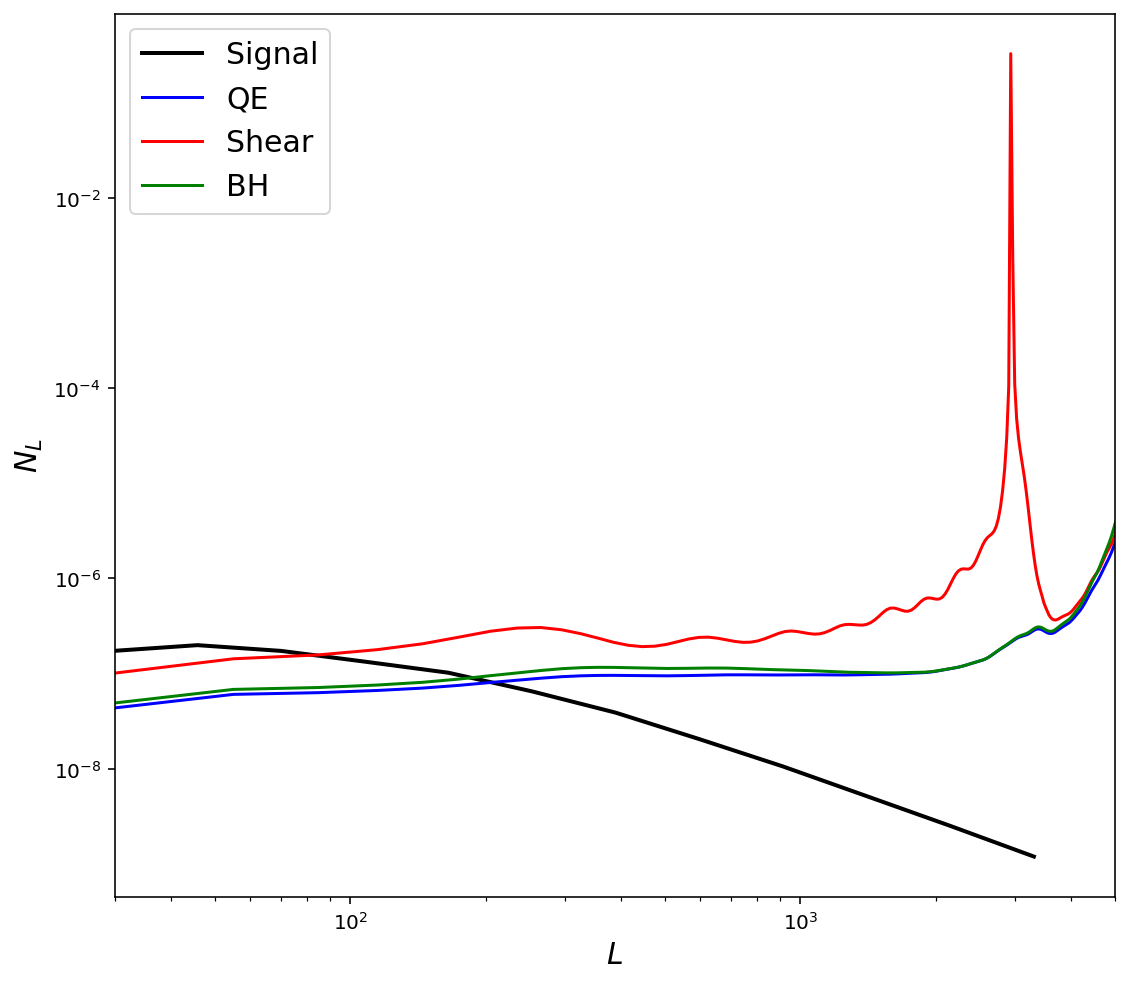

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (8, 7))
ax.plot(ells, kk, color = colors_ests['kk'], lw = 2, label = labels_ests['kk'])

for e_index, e in enumerate(estimators):
    ax.plot(el, noise_dict[e], color = colors_ests[e], label = labels_ests[e])
    
#for e_index, e in enumerate(estimators):
#    ax.plot(ells, noises[e_index, e_index], color = colors_ests[e], label = labels_ests[e])
    
    
ax.set_ylabel('$N_L$', size = 15)
ax.set_xlabel('$L$', size = 15)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(30, 5000)

ax.legend(prop = font)

fig.tight_layout()

fig.savefig(paperplots/'noises_3500.png', dpi = 300)
plt.show()

In [380]:
#ax[0].set_title(f'Best {names[i]}, h{h}_s{s}_b{b}', **csfont)
#fig.tight_layout()

In [381]:
lEdges = np.logspace(np.log10(10), np.log10(4000), 15, 10.)

In [382]:
deltal = lEdges[1:]-lEdges[:-1]

## Foregrounds biases

### Auto

In [383]:
fgnamefiles = ['tsz', 'cib', 'radiops', 'ksz', 'total']

In [384]:
lmax_fixed = 3500

In [385]:
foreground = {}
foreground['tsz'] = 'tSZ'
foreground['cib'] = 'CIB'
foreground['ksz'] = 'kSZ'
foreground['radiops'] = 'Radio'
foreground['total'] = 'Sum'

In [386]:
tri = 'Trispectrum'
pri = 'Primary'
pricross = 'Primary Cross'
sec = 'Secondary'
titles = [tri, pri, sec, pricross]

titles_tags = {}
titles_tags[tri] = trispectrumtag
titles_tags[pri] = primarytag
titles_tags[pricross] = primarycrosstag
titles_tags[sec] = secondarytag

In [387]:
ylims = {}

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.01
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.025

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[tri] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.1
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.025
ylim['ksz']['ymax'] = 0.025

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.025
ylim['radiops']['ymax'] = 0.1

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pri] = ylim

#######

ylim = {}

ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.1

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.01
ylim['ksz']['ymax'] = 0.01

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.01
ylim['radiops']['ymax'] = 0.01

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[pricross] = ylim

#######

ylim = {}
ylim['tsz'] = {}
ylim['tsz']['ymin'] = -0.05
ylim['tsz']['ymax'] = 0.05

ylim['ksz'] = {}
ylim['ksz']['ymin'] = -0.05
ylim['ksz']['ymax'] = 0.05

ylim['radiops'] = {}
ylim['radiops']['ymin'] = -0.05
ylim['radiops']['ymax'] = 0.05

ylim['cib'] = {}
ylim['cib']['ymin'] = -0.1
ylim['cib']['ymax'] = 0.1

ylim['total'] = {}
ylim['total']['ymin'] = -0.1
ylim['total']['ymax'] = 0.1

ylims[sec] = ylim

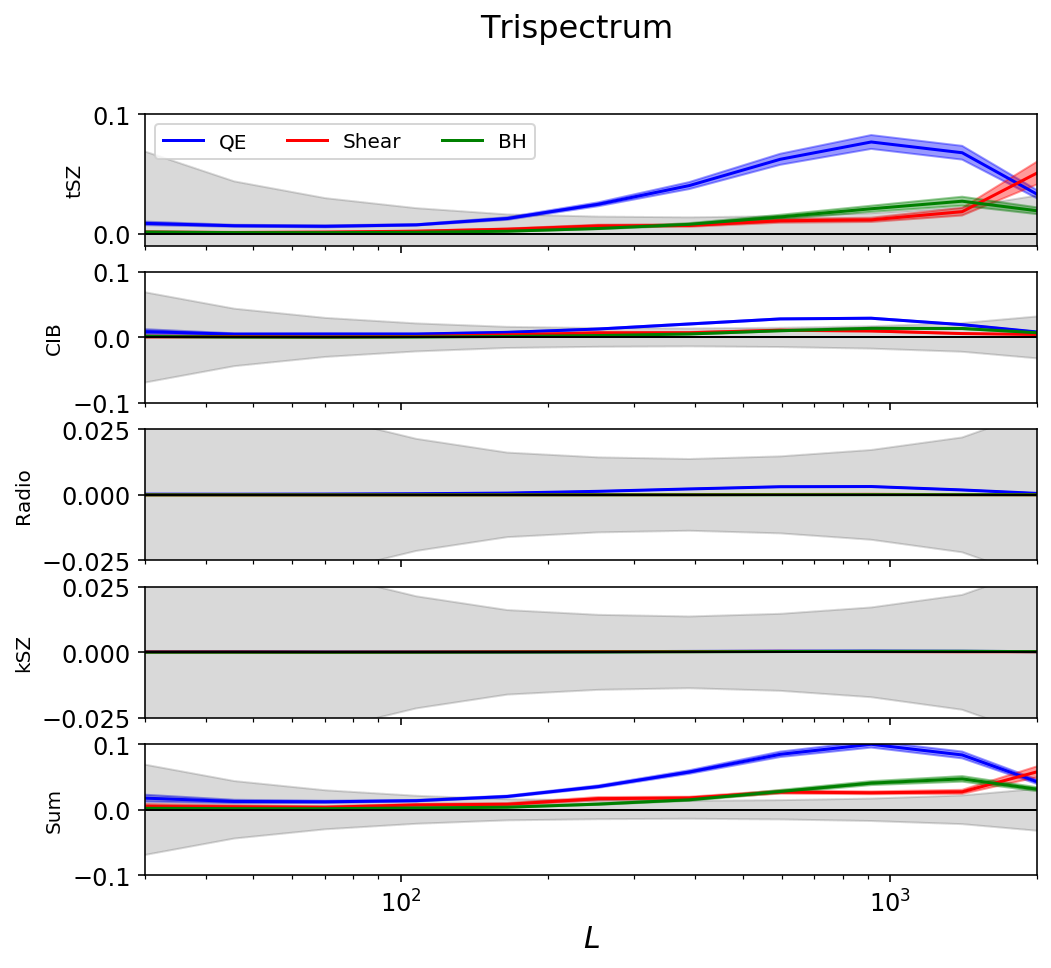

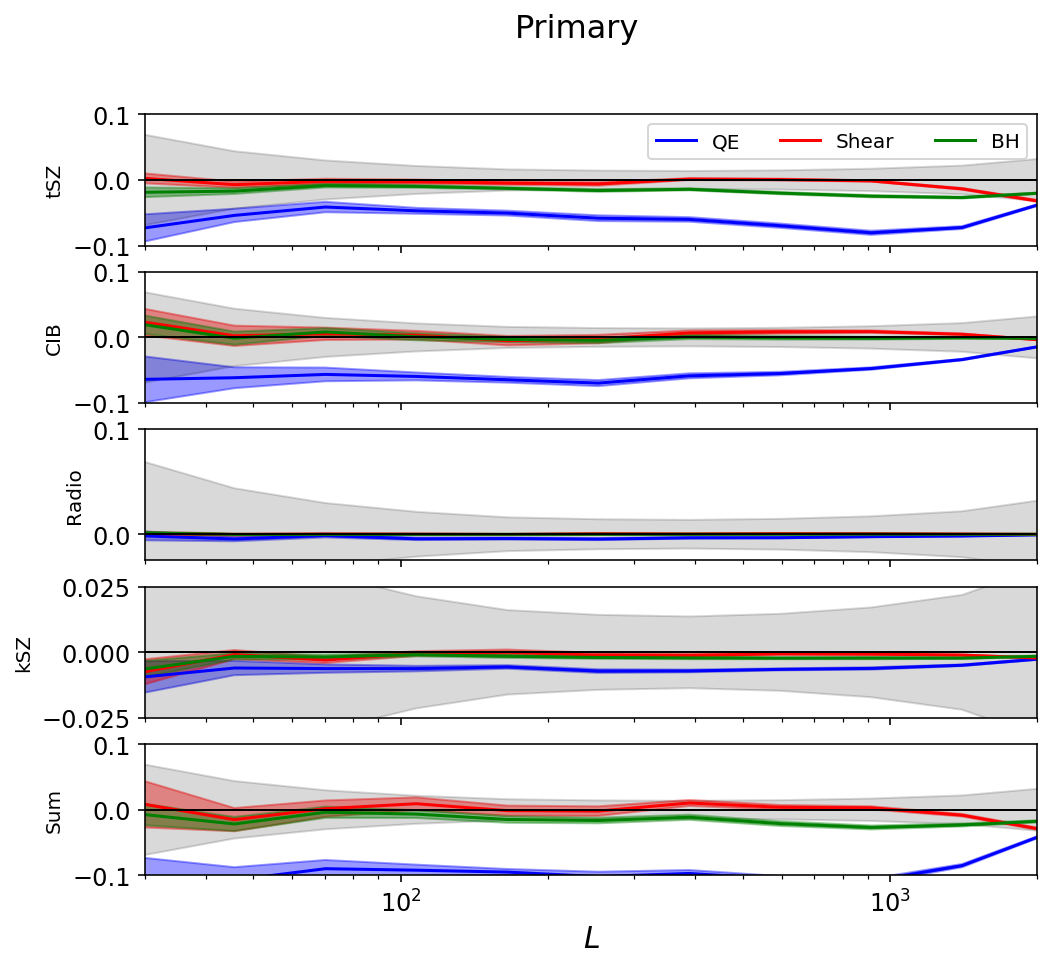

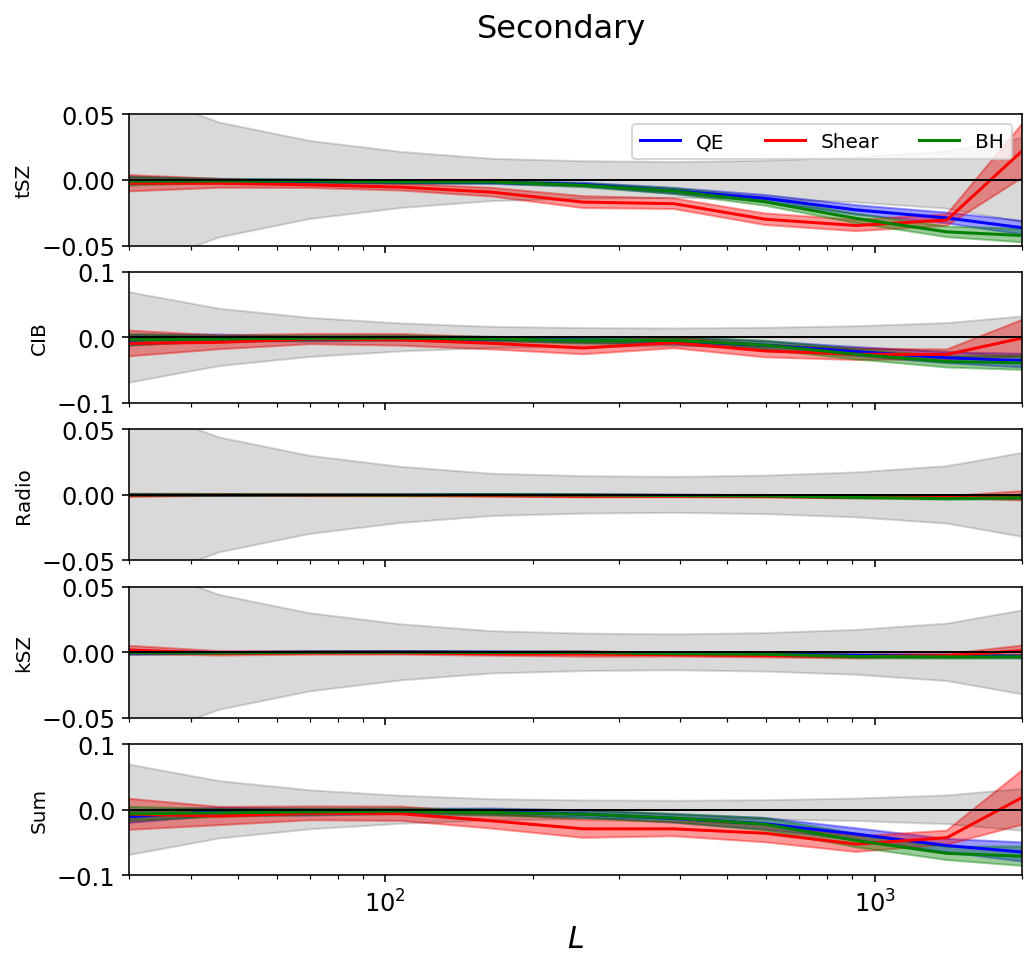

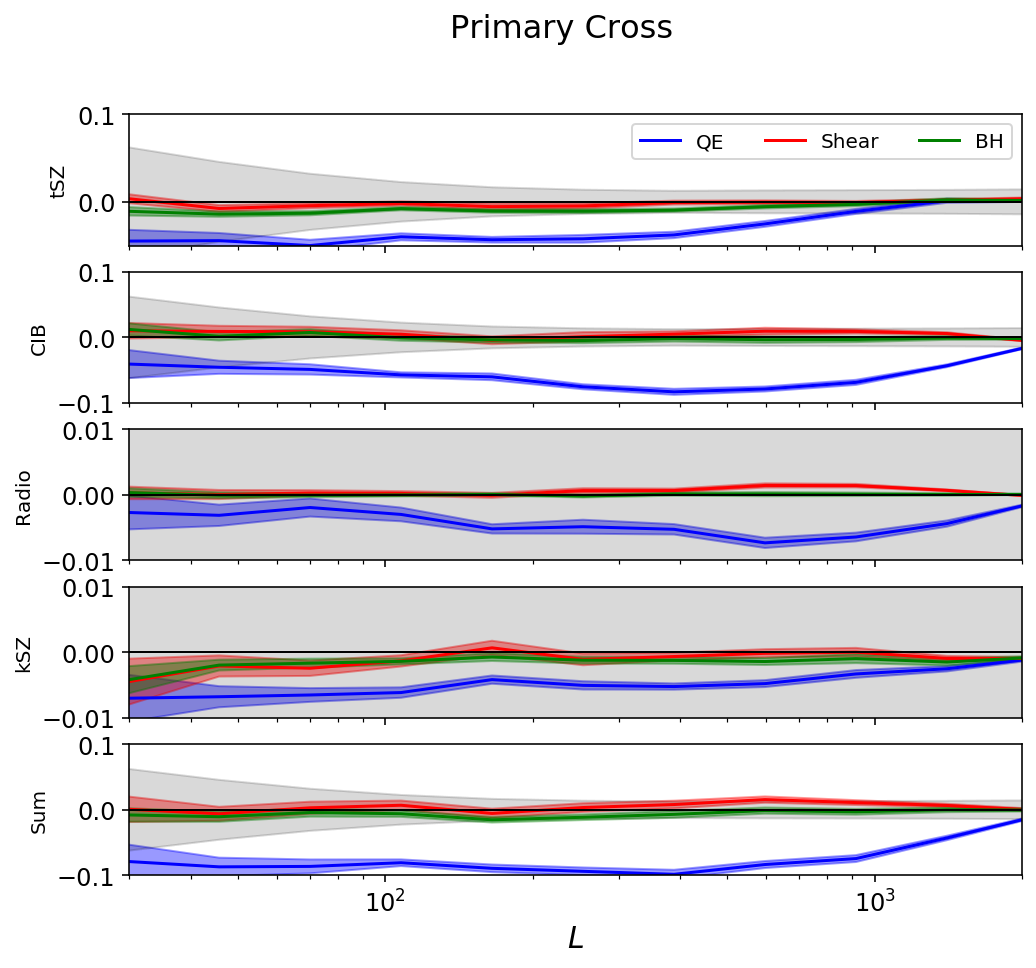

In [388]:
for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
    lmaxes_dict = {}
    lmax_directory = ''
    for e_index, e in enumerate(estimators):
        l = lmaxes[e_index]
        lmaxes_dict[e] = l
        lmax_directory += f'{names[e]}{l}'

    for t in titles:
        fig, ax = plt.subplots(nrows = len(fgnamefiles), ncols = 1, sharex = True, figsize = (8, 7))

        fig.suptitle(f'{t}', fontsize = 16, **csfont)

        #primary = get(primarytag)
        #secondary = get(secondarytag)
        #trispectrum = get(trispectrumtag)

        #primaryscatter = getscatter(primarytag)
        #secondaryscatter = getscatter(secondarytag)
        #trispectrumscatter = getscatter(trispectrumtag)

        for fgindex, fgnamefile in enumerate(fgnamefiles):
            
            P = PP/lmax_directory
            Pfg = PP/lmax_directory/fgnamefile

            getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
            get = lambda key: np.load(Pfg/getoutname(key))

            getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
            getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

            noises = get(noisetag)
            ells = get('ells')
            kk = get('kk')
            kg = get('kg')
            gg = get('gg')
        
            specificbias = get(titles_tags[t])
            specificscatter = getscatter(titles_tags[t])

            ylim = ylims[t]
            
            for e_index, e in enumerate(estimators):
                                
                    
                noise_k = noises[0, 0] #For QE
                kktot = kk+noise_k
                
                if specificscatter.ndim > 2:
                    err = specificscatter[e_index, e_index]/kk
                    y = specificbias[e_index, e_index]/kk
                    
                    stat_uncert = np.sqrt(2/(2*ells*deltal*fsky))*kktot/kk
                else:
                    err = specificscatter[e_index]/kg
                    y = specificbias[e_index]/kg
                    
                    stat_uncert = np.sqrt(1/(2*ells*deltal*fsky)*(kktot*gg+kg**2.))/kg
                

                ax[fgindex].plot(ells, y, color = colors_ests[e], label = labels_ests[e])
                ax[fgindex].fill_between(ells, y-err, y+err, color = colors_ests[e], alpha = 0.4)
                
                ax[fgindex].fill_between(ells, -stat_uncert, stat_uncert, color = 'black', alpha = 0.05)
                

                ax[fgindex].set_ylim(ymin = ylim[fgnamefile]['ymin'], ymax = ylim[fgnamefile]['ymax'])
                ax[fgindex].set_ylabel(f'{foreground[fgnamefile]}')
                ax[fgindex].set_ylim(ylim[fgnamefile]['ymin'], ylim[fgnamefile]['ymax'])
                ax[fgindex].set_xlim(30, 2000)
                ax[fgindex].axhline(y = 0, color = 'black', lw = 1)
                ax[fgindex].tick_params(axis = 'both', which = 'major', labelsize = 12)

        ax[-1].set_xscale('log')
        ax[-1].set_xlabel('$L$', size = 15)
        
        ax[0].legend(loc = "best", ncol = len(estimators))

        #fig.tight_layout()
        fig.savefig(paperplots/f'biases_{titles_tags[t]}_3500.png', dpi = 300)

        plt.show()

#### Cross check primary cross with Manu's code

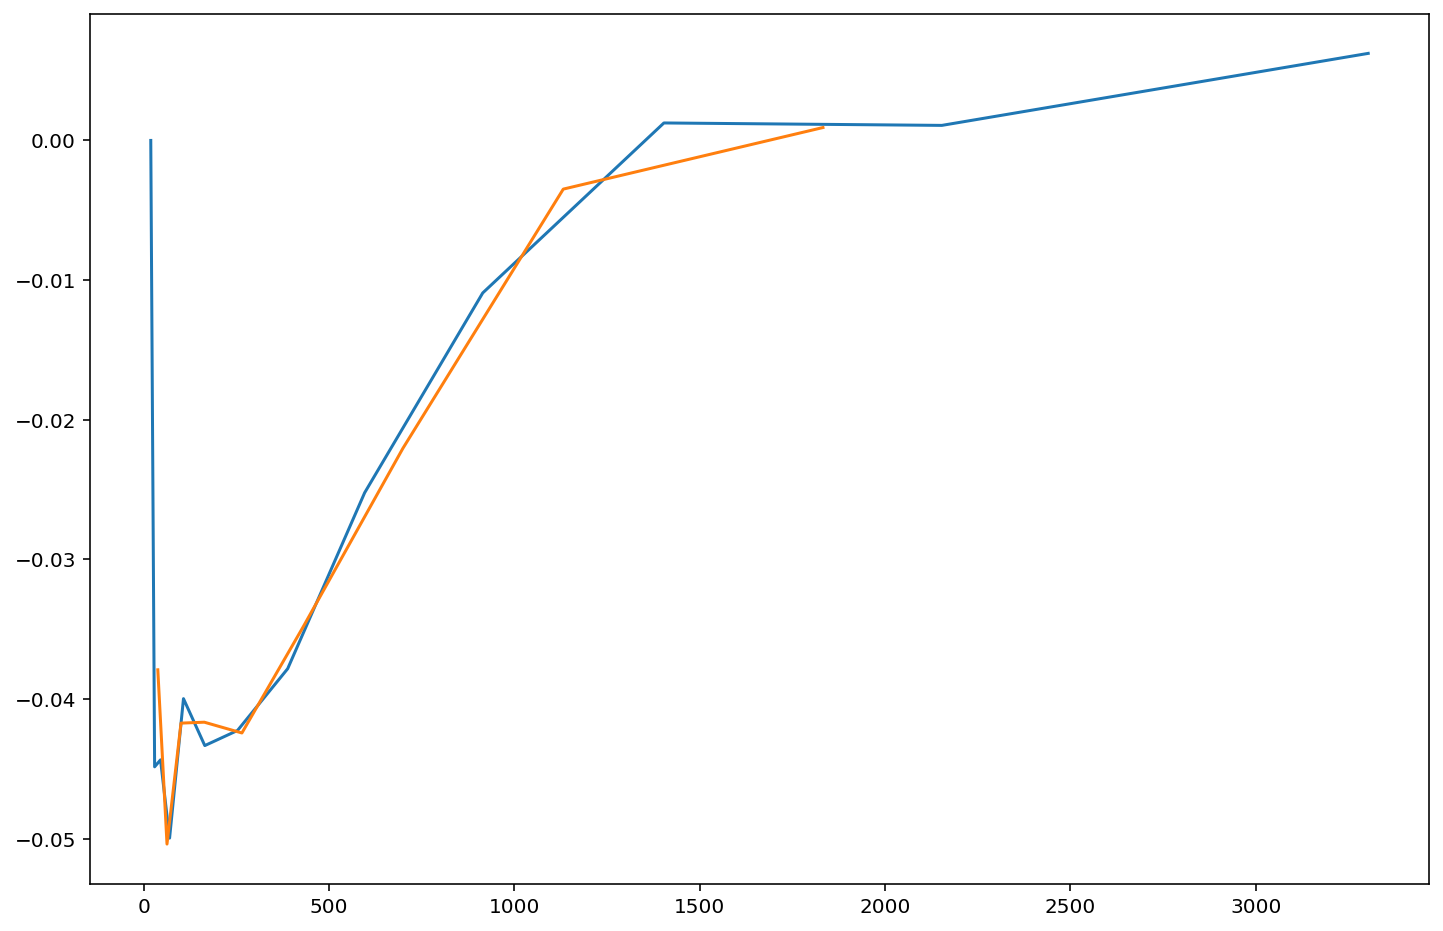

In [389]:
dictionary = u.dictionary(savingdirectory, 'h3500s3500b3500')

Nsims = 80
fgnamefile = 'tsz'

total = 0.
totalmanu = 0.
totalmanukg = 0.

for j in range(Nsims):
    dic = dictionary.read(f'{fgnamefile}_{nu}_{j}')
    total += dic['PC']['PC-hu_ok']
    
    direc = '/scratch/r/rbond/omard/CORI17112020/toNIAGARA24112020/LensQuEst-1/out_txt/'
    lCen, Clcross, signal = np.loadtxt(direc+f'QE_galonly_{j}.txt', unpack = True)
    totalmanu += Clcross
    totalmanukg += signal
    
total /= Nsims
totalmanu /= Nsims
totalmanukg /= Nsims

plt.plot(ells, total/kg)
selection = (lCen>30) & (lCen<2000)
plt.plot(lCen[selection], totalmanu[selection]/totalmanukg[selection])

### Alens parameter

In [390]:
import best

In [391]:
def get_lmax_directory(lmax_fixed, estimators):
    for lmaxes in [(lmax_fixed, lmax_fixed, lmax_fixed)]:
        lmaxes_dict = {}
        lmax_directory = ''
        for e_index, e in enumerate(estimators):
            l = lmaxes[e_index]
            lmaxes_dict[e] = l
            lmax_directory += f'{names[e]}{l}'
        return lmax_directory

In [392]:
lmaxes_list = np.arange(2000, 5000, 500)

In [393]:
colors_fgs = {}
colors_fgs['tsz'] = 'red'
colors_fgs['cib'] = 'blue'
colors_fgs['ksz'] = 'green'
colors_fgs['radiops'] = 'gold'
colors_fgs['total'] = 'cyan'

In [394]:
labels_fgs = {}
labels_fgs['tsz'] = 'tSZ'
labels_fgs['cib'] = 'CIB'
labels_fgs['ksz'] = 'kSZ'
labels_fgs['radiops'] = 'Radio'
labels_fgs['total'] = 'Sum'

In [395]:
autocase = 'auto'
crosscase = 'cross'
cases = [autocase, crosscase]

Doing hu_ok
Doing shear
Doing bh


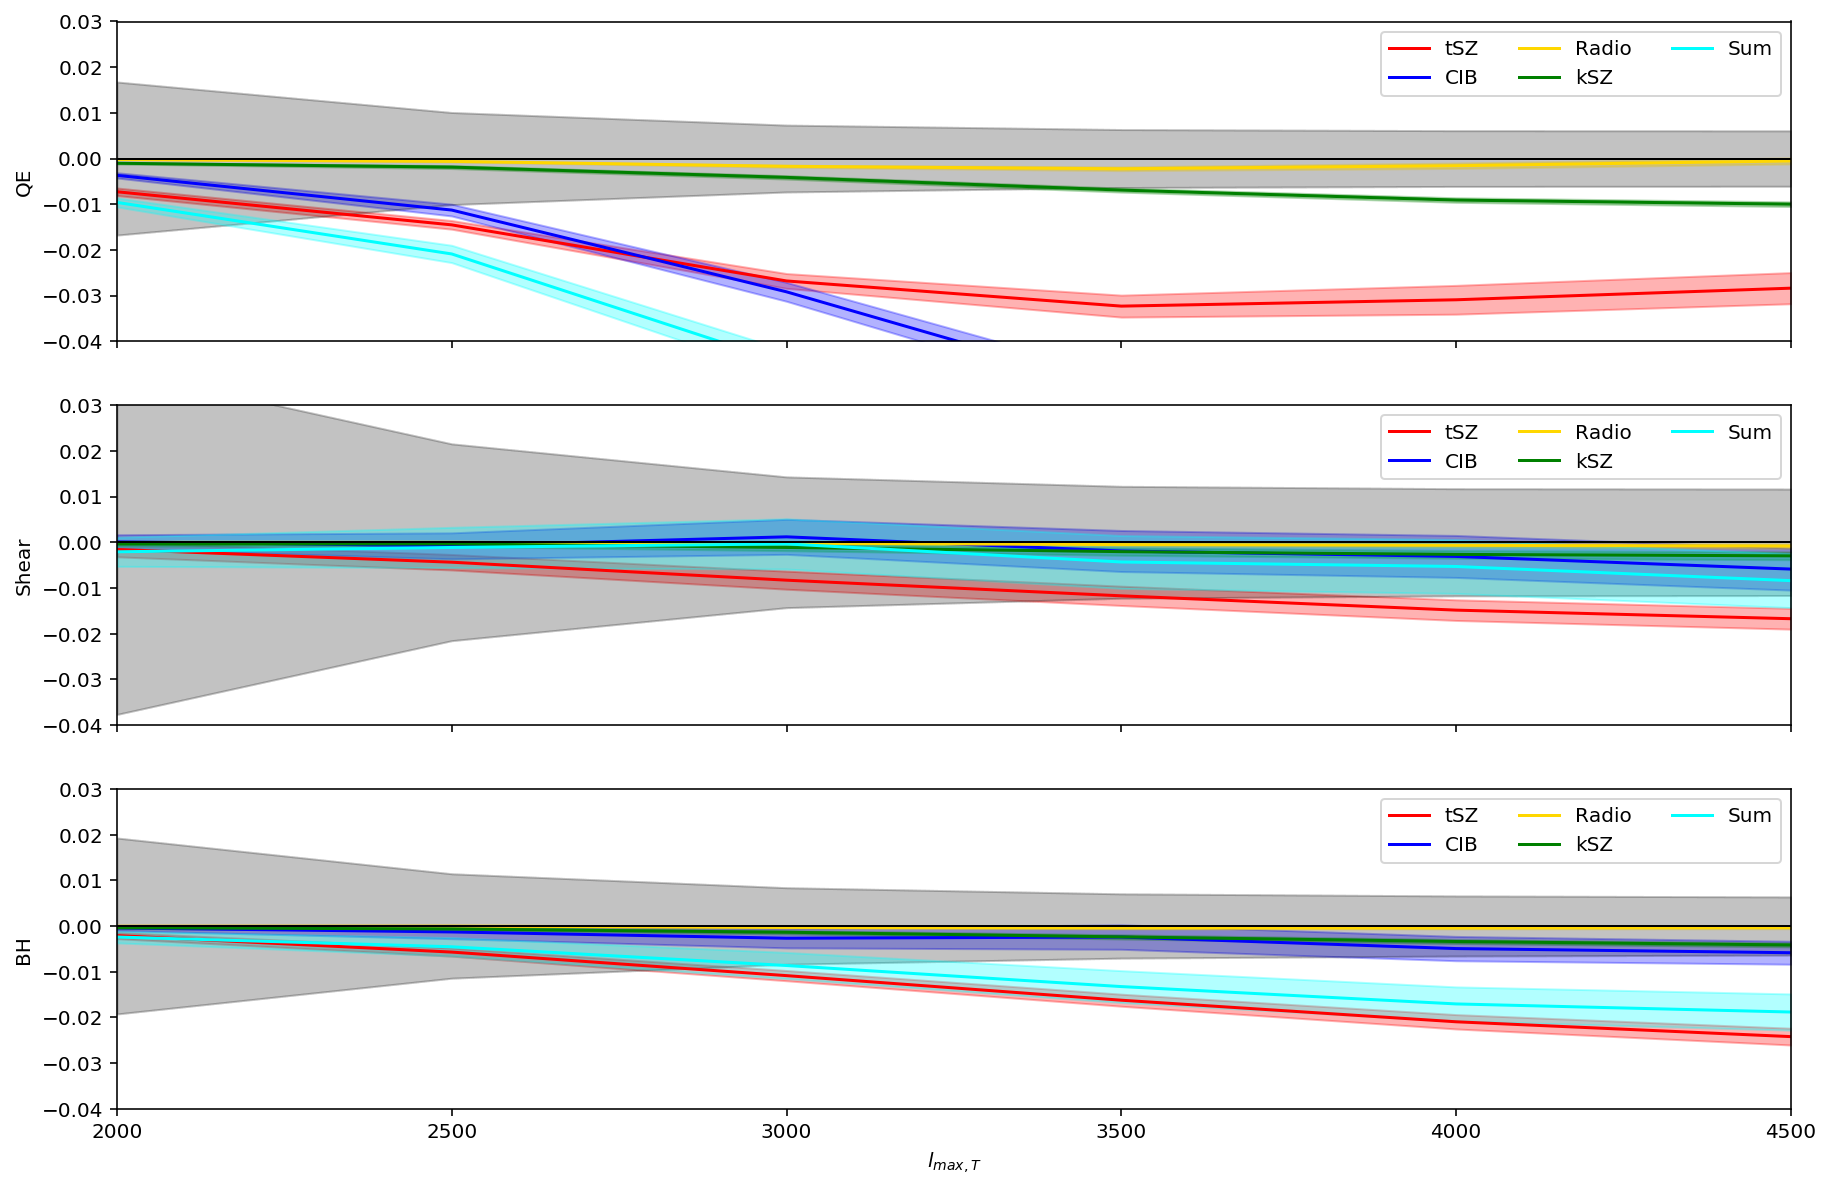

In [431]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))

    for index, estimator in enumerate(estimators):

        print(f'Doing {estimator}')

        for fgindex, fgnamefile in enumerate(fgnamefiles):

            noiseslist = []
            biaseslist = []
            
            scatters_list = []
            means_list = []

            for lmax_fixed in lmaxes_list: 

                lmax_directory = get_lmax_directory(lmax_fixed, estimators)
                
                P = PP/lmax_directory
                Pfg = PP/lmax_directory/fgnamefile

                getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                get = lambda key: np.load(Pfg/getoutname(key))

                getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                noises = get(noisetag)
                theta = get('theta')
                thetacross = get('thetacross')
                ells = get('ells')
                kk = get('kk')
                kg = get('kg')
                gg = get('gg')

                specificbias = get('totalbias')
                specificbiascross = get(primarycrosstag)
                
                #specificscatter = getscatter('totalbias')
                #specificscattercross = getscatter(primarycrosstag)
                
                if case == autocase:
                    Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                    Opt = Optauto
                elif case == crosscase:
                    Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, specificbiascross, noises)
                    Opt = Optcross

                f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                nbins = Opt.nbins
                zeros = np.zeros(3*nbins)
                for j in range(nbins):
                    zeros[index+3*j:index+(3*j+1)] = 1.

                noiseslist += [n(zeros)]
                biaseslist += [b(zeros)]
                
                dic = u.dictionary('output_biases/', lmax_directory)
                
                biasestags = [trispectrumtag, primarytag, secondarytag]
                
                total = []

                for j in range(Nsims):
                    dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                    temp = 0.
                    if case == autocase:
                        for k in biasestags:
                            temp += (u.get_element(dictionary[k], estimators))
                    elif case == crosscase:
                        temp += (u.get_element(dictionary[primarycrosstag], estimators))
                        
                    temp_bias = temp
                    
                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                        Opt = Optauto
                    elif case == crosscase:
                        Optcross = best.Opt(estimators, 30, 1200, ells, kg, thetacross, temp_bias, noises)
                        Opt = Optcross
                        
                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                          sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)
                    
                    total += [b(zeros)]
                    
                A, A_octanct = 81*20**2, 5156.6
                factor_err = np.sqrt(A/A_octanct)
                    
                mean, scatter = u.get_mean_and_scatter(Nsims, total)
                
                scatters_list += [scatter]
                means_list += [mean]
                
                
                

            noiseslist = np.array(noiseslist)
            biaseslist = np.array(biaseslist)
            
            scatters_list = np.array(scatters_list)*factor_err
            means_list = np.array(means_list)
            
            #print('Rapp', means_list/biaseslist)
            #print(scatters_list)
            
            ax[index].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
            ax[index].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
            
            ax[index].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

        ax[index].axhline(y = 0, color = 'black', lw = 1)
        ax[index].set_ylim(-0.04, 0.03)
        ax[index].set_ylabel(labels_ests[estimator])
        ax[index].legend(ncol = len(estimators))
        ax[-1].set_xlim(2000, 4500)
        ax[-1].set_xlabel('$l_{max,T}$')

    fig.savefig(paperplots/f'alens_{case}_biases.png', dpi = 300)
    plt.show()

PosixPath('output/h2000s2000b2000/tsz')

In [432]:
cases = ['auto']

Doing hu_ok-shear
Doing hu_ok-bh
Doing shear-bh


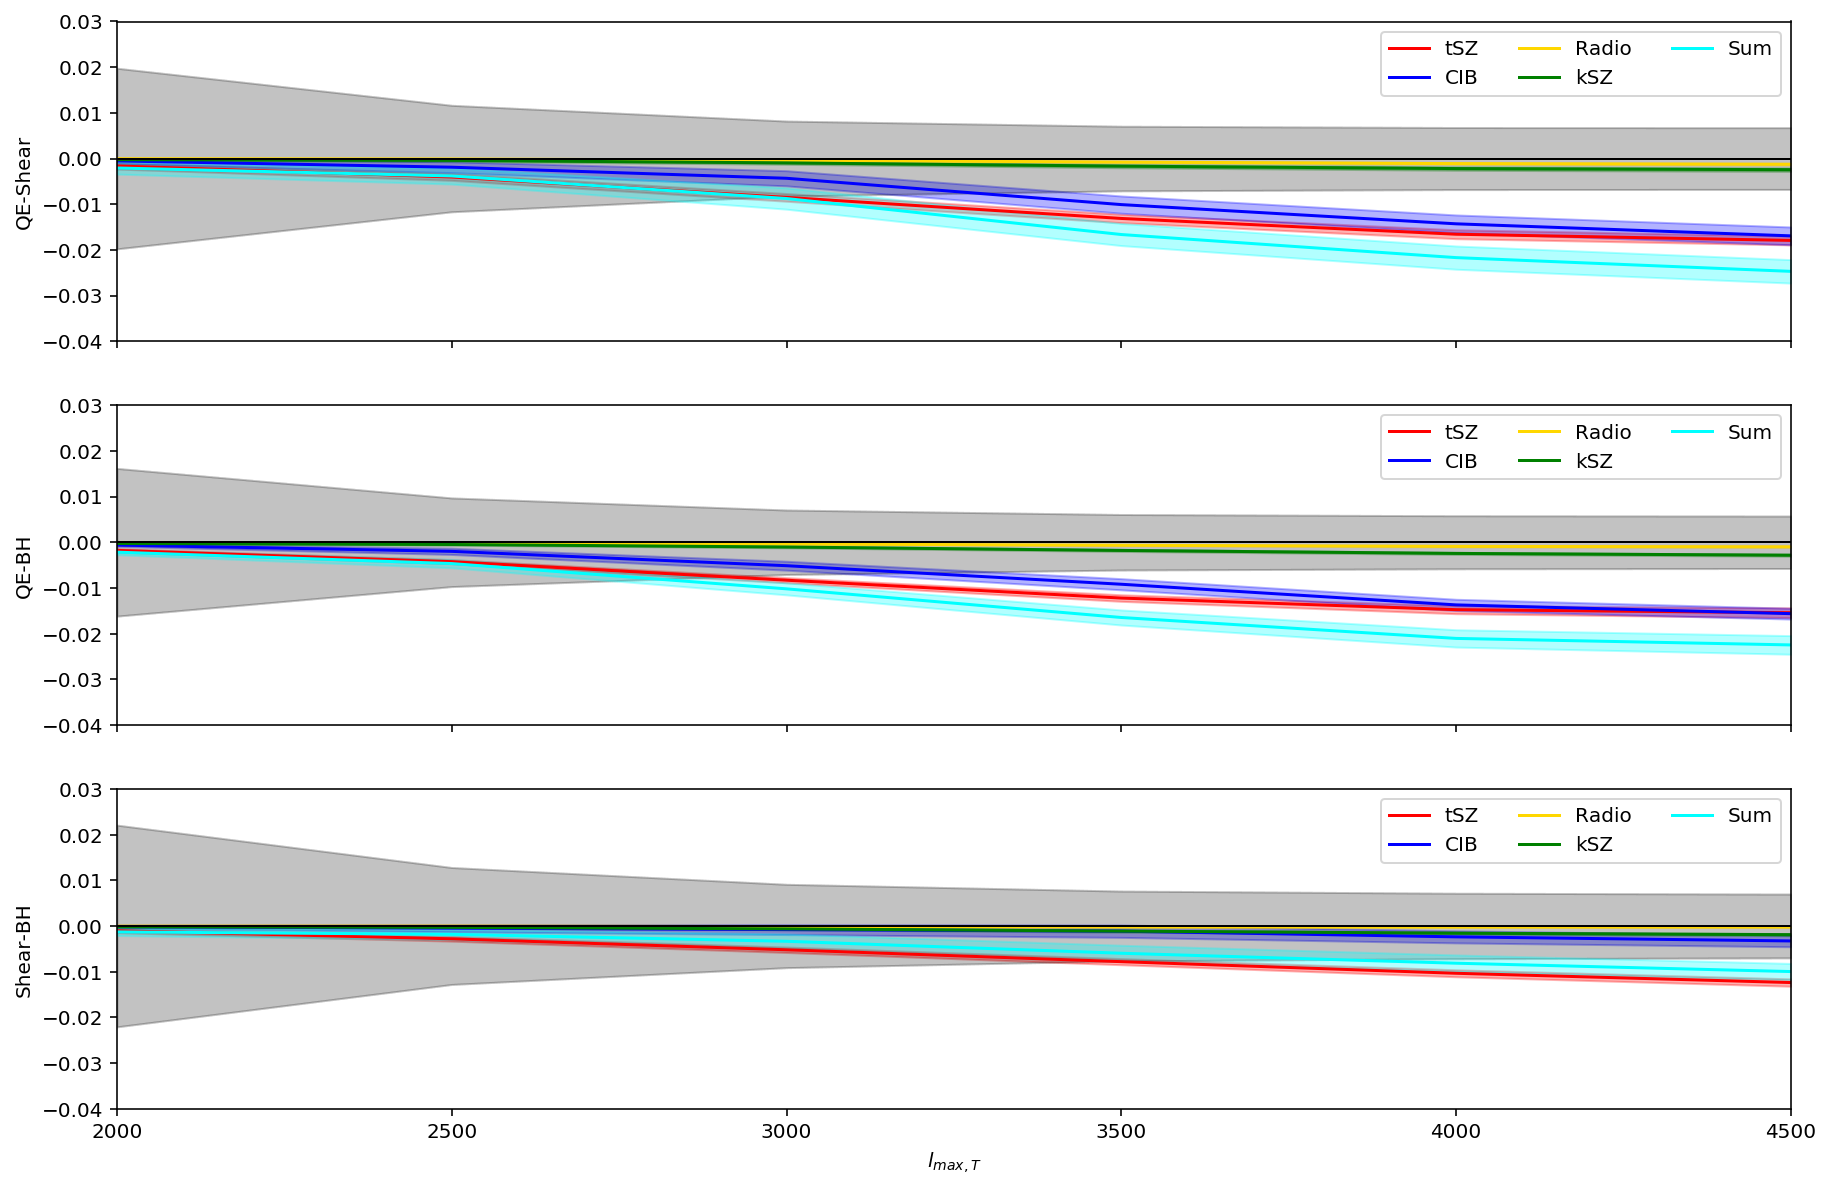

In [433]:
for case in cases:
    fig, ax = plt.subplots(nrows = len(estimators), sharex = True, figsize = (15, 10))
        
    kind = 0
    
    for index, estimator in enumerate(estimators):
        
        for index2 in range(index+1, len(estimators)):
             

            estimator2 = estimators[index2]

            print(f'Doing {estimator}-{estimator2}')

            for fgindex, fgnamefile in enumerate(fgnamefiles):

                noiseslist = []
                biaseslist = []
                
                scatters_list = []
                means_list = []

                for lmax_fixed in lmaxes_list: 

                    lmax_directory = get_lmax_directory(lmax_fixed, estimators)


                    P = PP/lmax_directory
                    Pfg = PP/lmax_directory/fgnamefile

                    getoutname = lambda key: f'{key}_{fgnamefile}_{nu}.npy'
                    get = lambda key: np.load(Pfg/getoutname(key))

                    getoutnamescatter = lambda key: f'scatter_{key}_{fgnamefile}_{nu}.npy'
                    getscatter = lambda key: np.load(Pfg/getoutnamescatter(key))

                    noises = get(noisetag)
                    theta = get('theta')
                    ells = get('ells')
                    kk = get('kk')
                    kg = get('kg')
                    gg = get('gg')

                    specificbias = get('totalbias')

                    #specificscatter = getscatter('totalbias')
                    
                    noises[index, index] *= 0.
                    theta[index, index, index, index] *= 0.
                    noises[index2, index2] *= 0.
                    theta[index2, index2, index2, index2] *= 0.
                    
                    specificbias[index, index] *= 0.
                    specificbias[index, index2] *= 0.

                    if case == autocase:
                        Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, specificbias, noises)
                        Opt = Optauto

                    f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                    nbins = Opt.nbins
                    zeros = np.zeros(3*nbins)
                    for j in range(nbins):
                        zeros[index+3*j:index+(3*j+1)] = 1./2.
                        zeros[index2+3*j:index2+(3*j+1)] = 1./2.

                    noiseslist += [n(zeros)]
                    biaseslist += [b(zeros)]
                    
                    dic = u.dictionary('output_biases/', lmax_directory)
                
                    biasestags = [trispectrumtag, primarytag, secondarytag]

                    total = []

                    for j in range(Nsims):
                        dictionary = dic.read(f'{fgnamefile}_{nu}_{j}')
                        temp = 0.
                        if case == autocase:
                            for k in biasestags:
                                temp += (u.get_element(dictionary[k], estimators))
                                
                        temp_bias = temp
                        
                        temp_bias[index, index] *= 0.
                        temp_bias[index, index2] *= 0.

                        if case == autocase:
                            Optauto = best.Opt(estimators, 30, 1200, ells, kk, theta, temp_bias, noises)
                            Opt = Optauto

                        f, n, b = Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected, 
                              sum_biases_squared = False, bias_squared = False, fb = 0., inv_variance = True)

                        total += [b(zeros)]

                    A, A_octanct = 81*20**2, 5156.6
                    factor_err = np.sqrt(A/A_octanct)

                    mean, scatter = u.get_mean_and_scatter(Nsims, total)

                    scatters_list += [scatter]
                    means_list += [mean]
                
                
                scatters_list = np.array(scatters_list)*factor_err
                means_list = np.array(means_list)

                noiseslist = np.array(noiseslist)
                biaseslist = np.array(biaseslist)
                ax[kind].plot(lmaxes_list, biaseslist, color = colors_fgs[fgnamefile], label = labels_fgs[fgnamefile])
                ax[kind].fill_between(lmaxes_list, -noiseslist, noiseslist, color = 'black', alpha = 0.05)
                
                ax[kind].fill_between(lmaxes_list, biaseslist-scatters_list, biaseslist+scatters_list, color = colors_fgs[fgnamefile], alpha = 0.3)

            ax[kind].axhline(y = 0, color = 'black', lw = 1)
            ax[kind].set_ylim(-0.04, 0.03)
            ax[kind].set_ylabel(labels_ests[estimator]+'-'+labels_ests[estimator2])
            ax[kind].legend(ncol = len(estimators))
            ax[-1].set_xlim(2000, 4500)
            ax[-1].set_xlabel('$l_{max,T}$')

            kind += 1
            
    fig.savefig(paperplots/f'alens_{case}_crosses_biases.png', dpi = 300)
    plt.show()

### SNR vs Bias

### Optimization

In [178]:
def get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalabsbias'))

    biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')

    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)

    dic.read(f'results_fb_{fb}')
    
    return dic

In [251]:
def get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    
    
    if noisebiasconstr:
        n_equals_b_dir = 'noiseequalsbias'
    else:
        n_equals_b_dir = ''

    if invvariance:
        inv_variance_dir = 'inversevariance'
    else:
        inv_variance_dir = ''
    
    PP = pathlib.Path(analysis_directory)

    P = PP/lmax_directory
    

    getoutname = lambda key: f'{key}_{nu}.npy'
    noises = np.load(P/getoutname(noisetag))

    biases = np.load(P/getoutname('sum_all_totalabsbias'))

    biasescross = np.load(P/getoutname('sum_all_crosstotalabsbias'))

    kg = np.load(P/getoutname('kg'))
    kk = np.load(P/getoutname('kk'))
    gg = np.load(P/getoutname('gg'))
    ells = np.load(P/getoutname('ells'))
    theta = np.load(P/getoutname('theta'))
    thetacross = np.load(P/getoutname('thetacross'))

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Optimizerkg = best.Opt(estimators, lmin_sel, lmax_sel, ells, kg, thetacross, biasescross, noises)
    
    resultkk = best.Res(None, None)
    resultkk.load_all(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'auto_fb_{fb}')
    biases = resultkk.load(pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir, f'biases')

    directory_of_saving = pathlib.Path(results_directory)/lmax_directory/inv_variance_dir/n_equals_b_dir
    dic = u.dictionary(directory_of_saving)
    
    dic.read(f'results_fb_{fb}')
    
    wh = dic.dictionary['auto']['wh']
    ws = dic.dictionary['auto']['ws']
    wbh = dic.dictionary['auto']['wbh']
    wl = dic.dictionary['auto']['wl']
    
    
    a = np.c_[wh, ws, wbh]
    wsa = (wh, ws, wbh, wl)
    
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)
    
    
    wh = dic.dictionary['cross']['wh']
    ws = dic.dictionary['cross']['ws']
    wbh = dic.dictionary['cross']['wbh']
    wl = dic.dictionary['cross']['wl']
    
    wsc = (wh, ws, wbh, wl)
    
    a = np.c_[wh, ws, wbh]
    
    combinedcn = Optimizerkg.get_bias_part(a, Optimizerkg.noises_selected)
    combinedcb = Optimizerkg.get_bias_part(a, Optimizerkg.biases_selected)
    
    return wsa, wsc, Optimizerkk, Optimizerkg, combinedn, combinedb, combinedcn, combinedcb

In [252]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)


def get_est_weights(Opt, index, invvar):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
   '''
    nbins = Opt.nbins
    zeros = np.zeros(3*nbins)
    for j in range(nbins):
        zeros[index+3*j:index+(3*j+1)] = 1.
    return zeros

In [452]:

def get_ws(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):

    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    w1, w2, w3, wl = dic.dictionary['auto']['wh'], dic.dictionary['auto']['ws'], dic.dictionary['auto']['wbh'], dic.dictionary['auto']['wl']

    w1c, w2c, w3c, wlc = dic.dictionary['cross']['wh'], dic.dictionary['cross']['ws'], dic.dictionary['cross']['wbh'], dic.dictionary['cross']['wl']
    
    return dic.dictionary['ells'], w1, w2, w3, wl, w1c, w2c, w3c, wlc



def get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['total'], dic.dictionary['cross']['total']
    return auto, cross

def get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['noise'], dic.dictionary['cross']['noise']
    
    h, s, b = dic.dictionary['auto']['noisehuok'], dic.dictionary['auto']['noiseshear'], dic.dictionary['auto']['noisebh']
    hc, sc, bc = dic.dictionary['cross']['noisehuok'], dic.dictionary['cross']['noiseshear'], dic.dictionary['cross']['noisebh']
    
    return auto, cross, h, s, b, hc, sc, bc

def get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb):
    dic = get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)     
    auto, cross = dic.dictionary['auto']['bias'], dic.dictionary['cross']['bias']
    
    h, s, b = dic.dictionary['auto']['biashuok'], dic.dictionary['auto']['biasshear'], dic.dictionary['auto']['biasbh']
    
    hc, sc, bc = dic.dictionary['cross']['biashuok'], dic.dictionary['cross']['biasshear'], dic.dictionary['cross']['biasbh']
    
    return auto, cross, h, s, b, hc, sc, bc

In [435]:
def plot_fixed(fb, all_lmaxes_directories):
        fig, ax = plt.subplots(nrows = 5, sharex = True)

        fig2, ax2 = plt.subplots(nrows = 4, sharex = True)

        fig.suptitle(f'Case of fb = {fb}')

        fig2.suptitle(f'Cross Case of fb = {fb}')

        for fgnamefile in [fgnamefiles[0]]:
            for allmaxes in all_lmaxes_directories:
                print(allmaxes)
                h, s, b = re.findall(r'\d+', allmaxes)
                lmaxes_configs = [(h, s, b)]
                for lmaxes in lmaxes_configs:
                    lmaxes_dict = {}
                    lmax_directory = ''
                    for e_index, e in enumerate(estimators):
                        l = lmaxes[e_index]
                        lmaxes_dict[e] = l
                        lmax_directory += f'{names[e]}{l}'

                    #print('Doing for', lmax_directory)
                    invvariance = False
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)

                    ells = Opt.ells_selected

                    b = Opt.biases_selected
                    n = Opt.noises_selected

                    ax[0].plot(ells, combinedb, color = 'purple', label = 'Combined', marker = 'o')
                    ax[0].plot(ells, b[0, 0], color = 'blue', label = 'H')
                    ax[0].plot(ells, b[1, 1], color = 'red', label = 'S')
                    ax[0].plot(ells, b[2, 2], color = 'green', label = 'B')

                    ax[1].plot(ells, combinedn, color = 'purple', label = 'Combined', marker = 'o')
                    ax[1].plot(ells, n[0, 0], color = 'blue', label = 'H')
                    ax[1].plot(ells, n[1, 1], color = 'red', label = 'S')
                    ax[1].plot(ells, n[2, 2], color = 'green', label = 'B')

                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', label = 'H')
                    ax[2].plot(ells, w2, color = 'red', label = 'S')
                    ax[2].plot(ells, w3, color = 'green', label = 'B')

                    ax[3].plot(ells, wl, color = 'black')
                    
                    ax[4].plot(ells, w1*wl*ells, color = 'blue', label = 'H')
                    ax[4].plot(ells, w2*wl*ells, color = 'red', label = 'S')
                    ax[4].plot(ells, w3*wl*ells, color = 'green', label = 'B')




                    b = Optkg.biases_selected
                    n = Optkg.noises_selected

                    w1, w2, w3, wl = wsc

                    ax2[0].plot(ells, combinedcb, color = 'purple', label = 'Combined', marker = 'o')
                    ax2[0].plot(ells, b[0], color = 'blue', label = 'H')
                    ax2[0].plot(ells, b[1], color = 'red', label = 'S')
                    ax2[0].plot(ells, b[2], color = 'green', label = 'B')


                    ax2[1].plot(ells, w1, color = 'blue', label = 'H')
                    ax2[1].plot(ells, w2, color = 'red', label = 'S')
                    ax2[1].plot(ells, w3, color = 'green', label = 'B')

                    ax2[2].plot(ells, wl, color = 'black')
                    
                    ax2[3].plot(ells, w1*wl*ells, color = 'blue', label = 'H')
                    ax2[3].plot(ells, w2*wl*ells, color = 'red', label = 'S')
                    ax2[3].plot(ells, w3*wl*ells, color = 'green', label = 'B')


                    invvariance = True
                    ws, wsc, Opt, Optkg, combinedn, combinedb, combinedcn, combinedcb = get_combined_stuff(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                                 fgnamefile, lmax_directory, fb)


                    w1, w2, w3, wl = ws

                    ax[2].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax[2].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax[3].plot(ells, wl, color = 'black', ls = '--', alpha = 0.4)
                    
                    ax[4].plot(ells, w1*wl*ells, color = 'blue', label = 'H', ls = '--', alpha = 0.4)
                    ax[4].plot(ells, w2*wl*ells, color = 'red', label = 'S', ls = '--', alpha = 0.4)
                    ax[4].plot(ells, w3*wl*ells, color = 'green', label = 'B', ls = '--', alpha = 0.4)

                    w1, w2, w3, wl = wsc

                    ax2[1].plot(ells, w1, color = 'blue', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w2, color = 'red', ls = '--', alpha = 0.4)
                    ax2[1].plot(ells, w3, color = 'green', ls = '--', alpha = 0.4)

                    ax2[2].plot(ells, wl, color = 'black', ls = '--', alpha = 0.4)
                    
                    ax2[3].plot(ells, w1*wl*ells, color = 'blue', label = 'H', ls = '--', alpha = 0.4)
                    ax2[3].plot(ells, w2*wl*ells, color = 'red', label = 'S', ls = '--', alpha = 0.4)
                    ax2[3].plot(ells, w3*wl*ells, color = 'green', label = 'B', ls = '--', alpha = 0.4)


        ax[0].set_ylabel('$B$')
        ax[1].set_ylabel('$N$')
        ax[2].set_ylabel('$W$')
        ax[3].set_ylabel('$W_L$')
        ax[4].set_ylabel('$LWW_L$')
        ax[0].set_xscale('log')
        ax[0].legend(ncol = 4)

        ax2[0].set_ylabel('$B$')
        ax2[1].set_ylabel('$W$')
        ax2[2].set_ylabel('$W_L$')
        ax2[3].set_ylabel('$LWW_L$')
        ax2[0].set_xscale('log')
        ax2[0].legend(ncol = 4)

        plt.show()




#### Check a fixed config

In [436]:
fbs = [0., 1.]

In [437]:
all_lmaxes_directories = ['h3500s3500b3500']

h3500s3500b3500


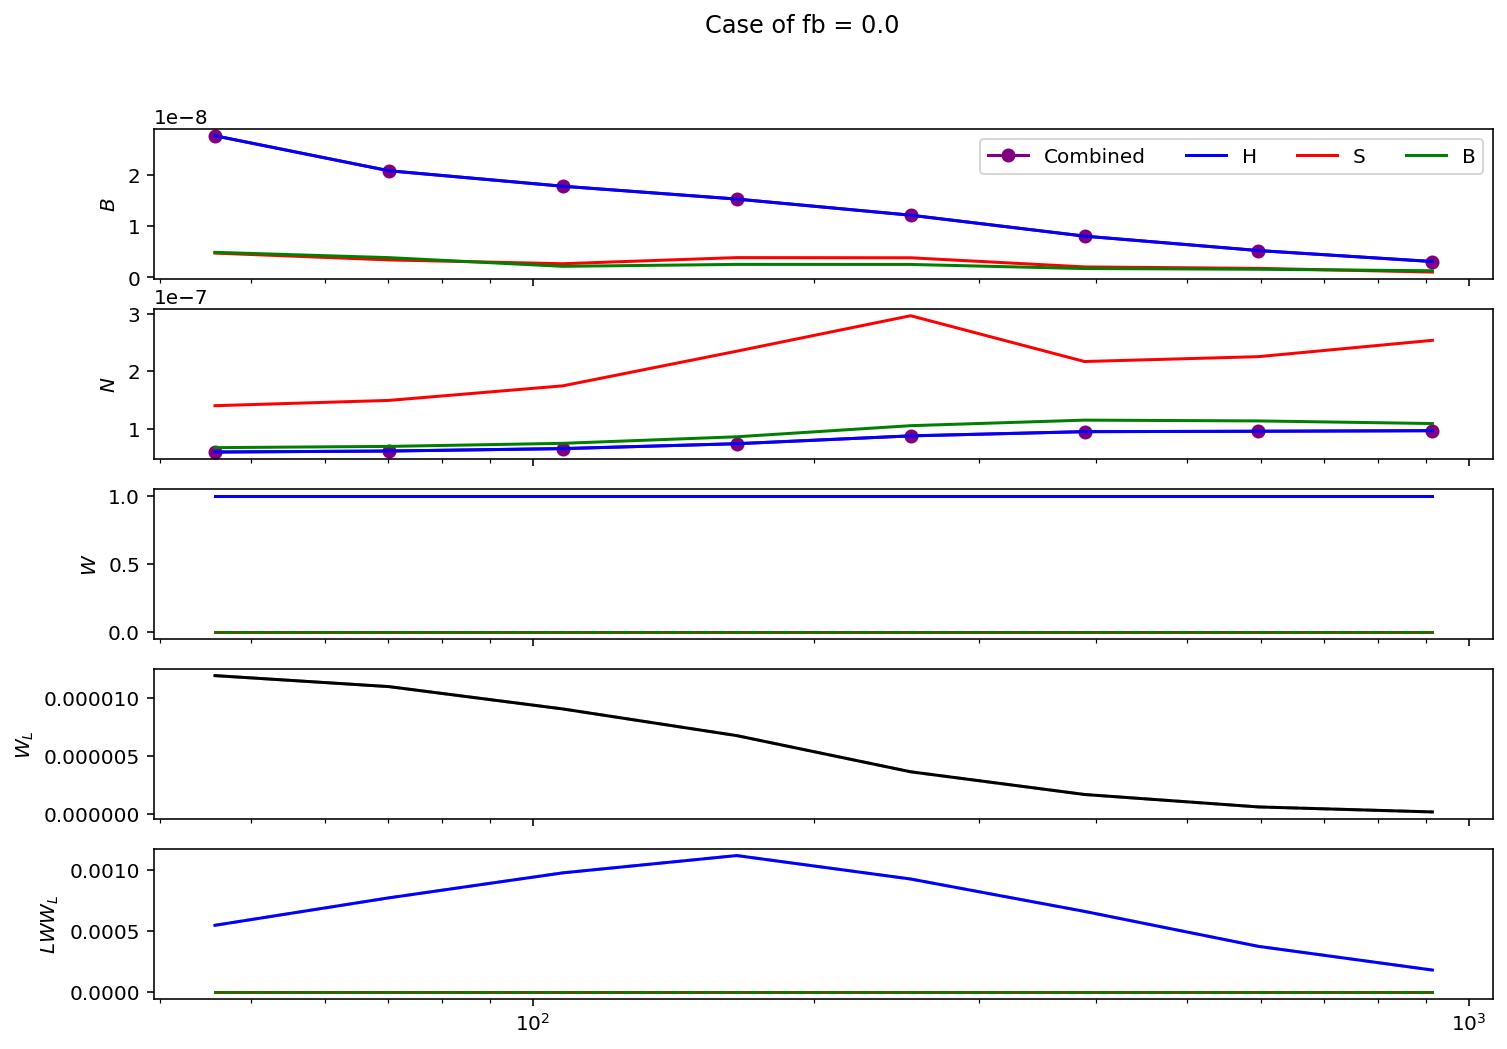

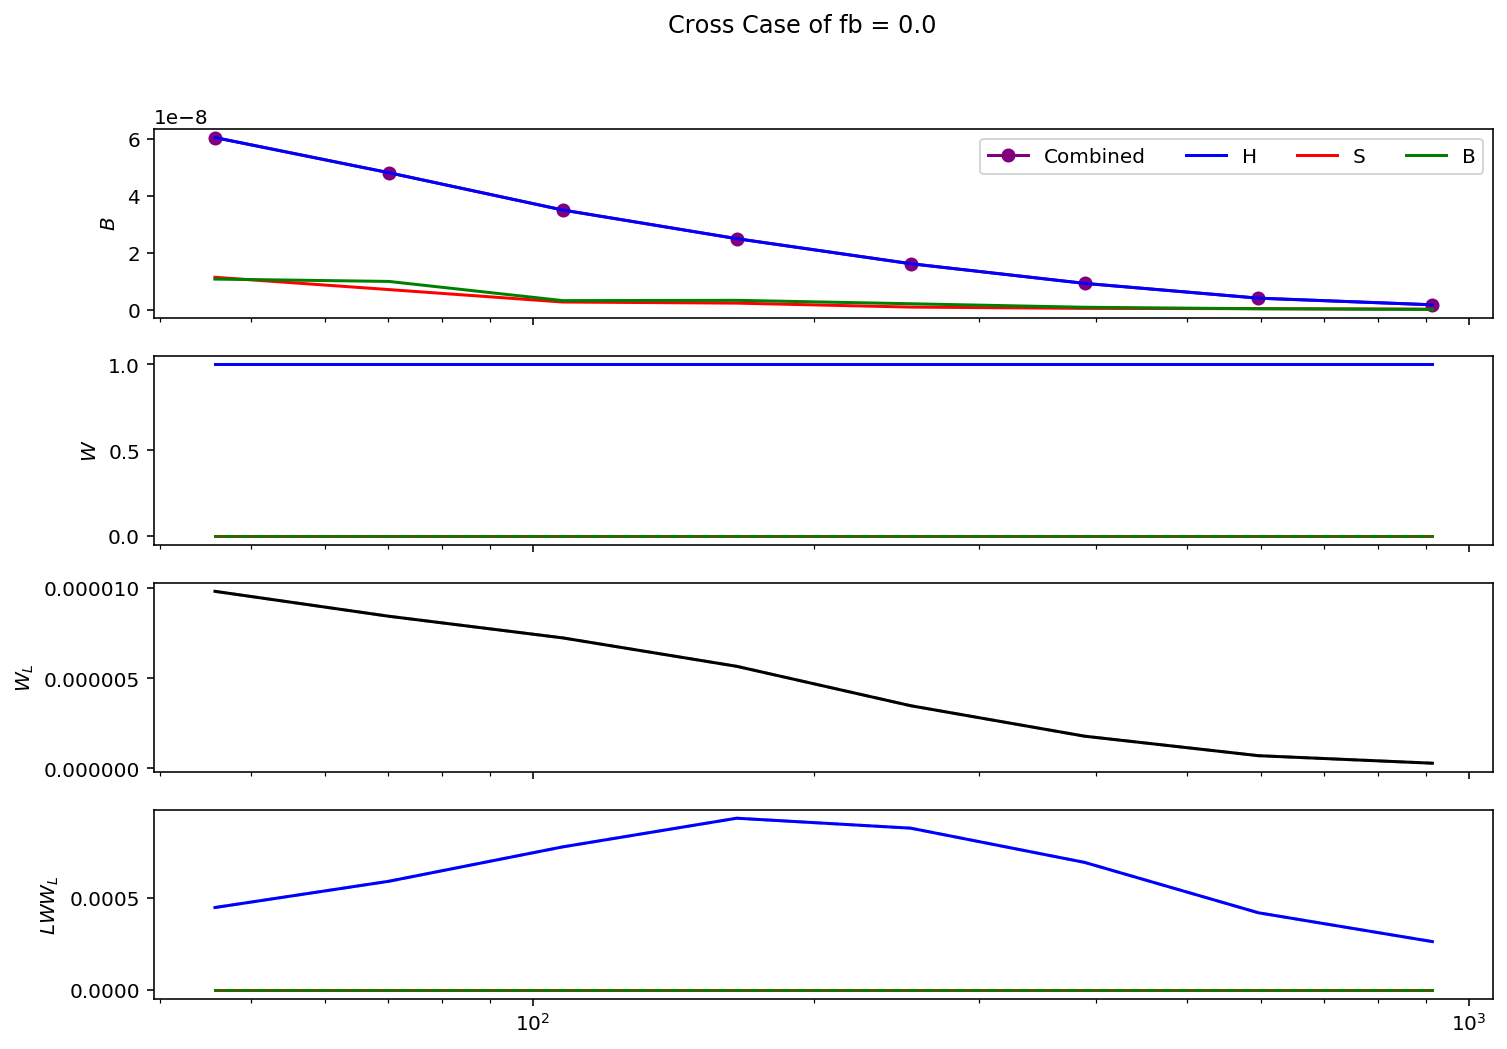

h3500s3500b3500


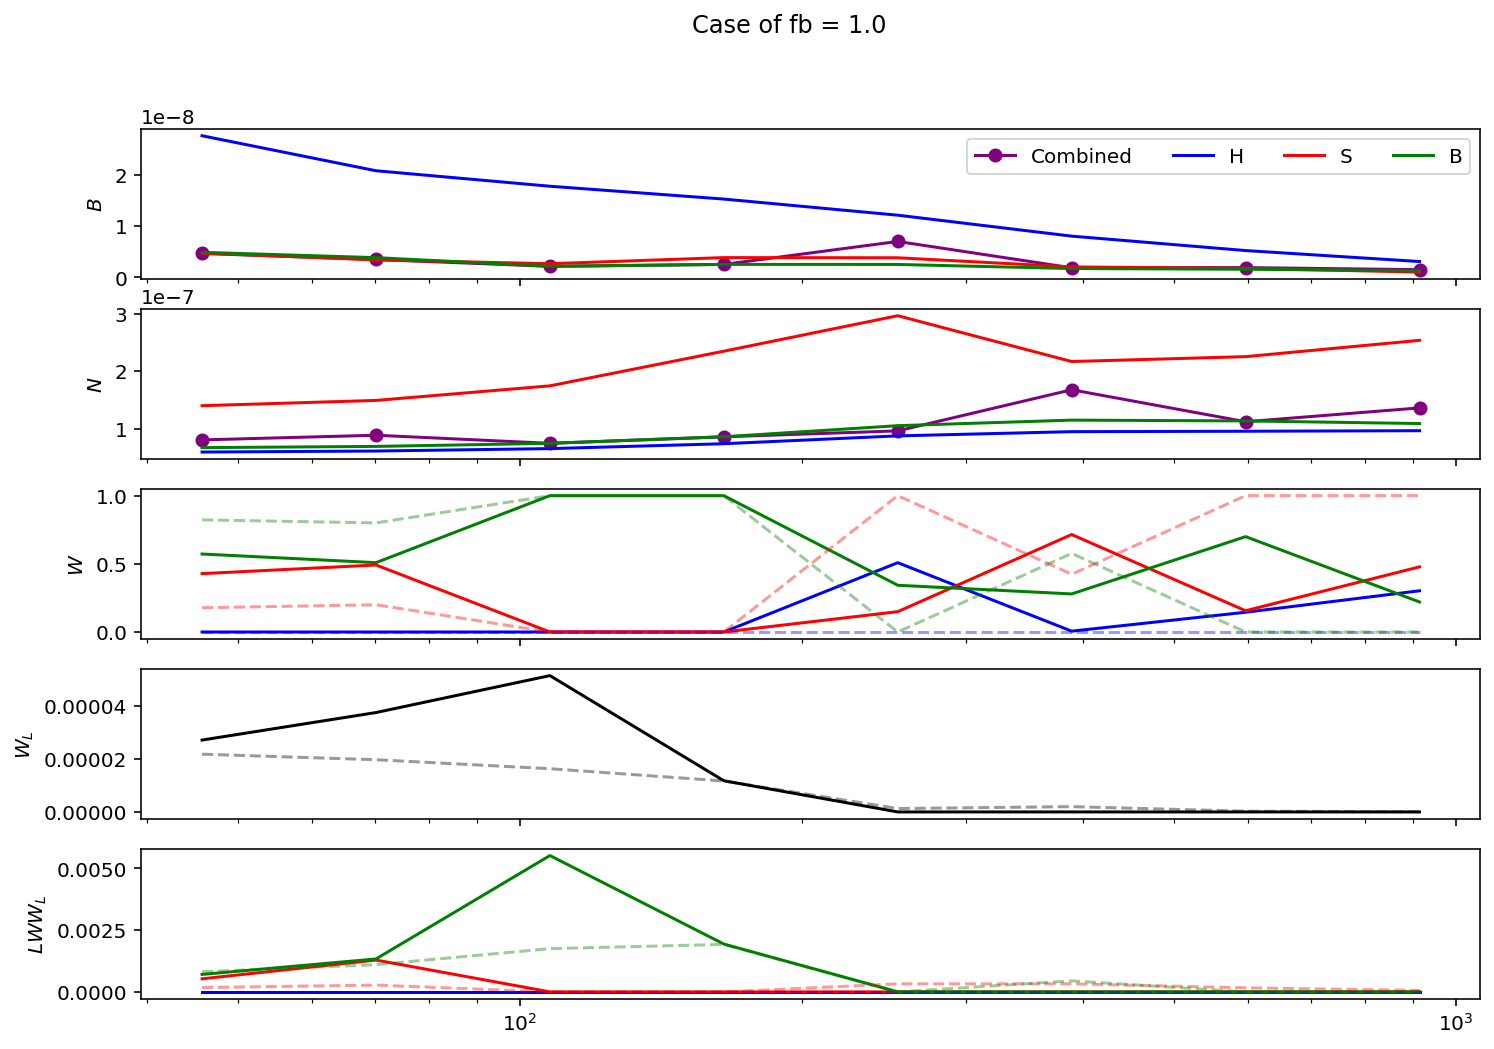

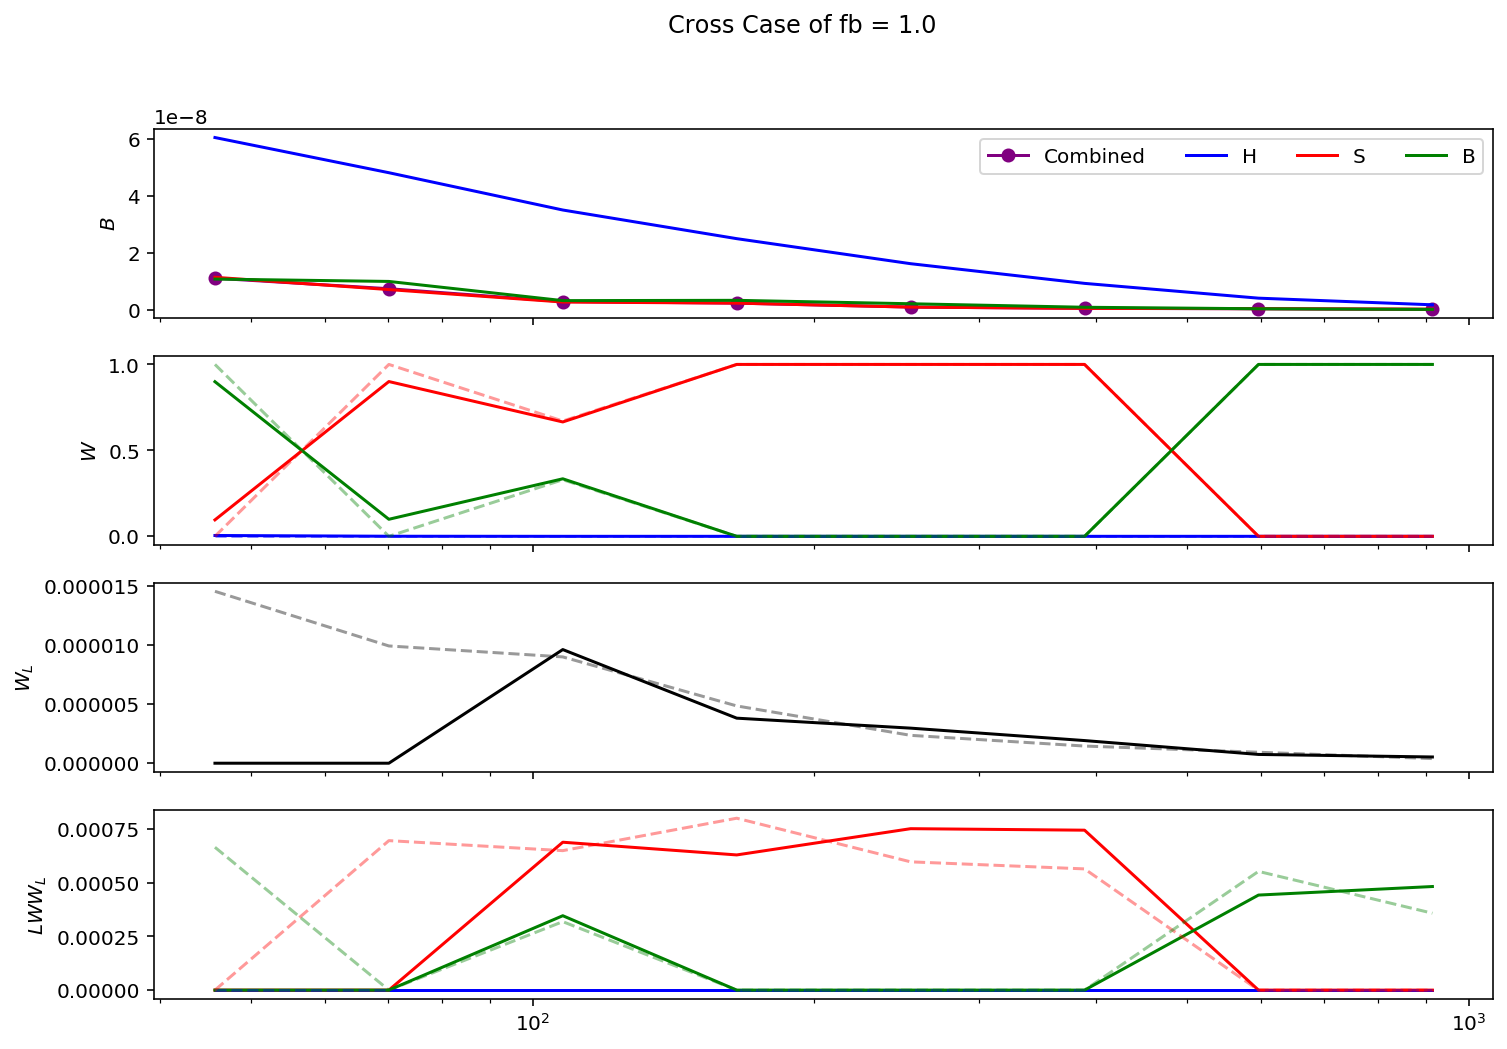

In [438]:
for fb in fbs:
    plot_fixed(fb, all_lmaxes_directories)

#### Run min for fb = 0., fb = 1.

In [439]:
path = pathlib.Path('output/')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]

In [440]:
invvariance = False

In [441]:
fb = 1.

In [495]:
autos = {}
crosses = {}

la = []
lc = []

lamv = []
lcmv = []

autosn = {}
crossesn = {}

lan = []
lcn = []

lanmv = []
lcnmv = []

autosb = {}
crossesb = {}

lab = []
lcb = []

labmv = []
lcbmv = []

lBh = []
lBs = []
lBb = []
lNh = []
lNs = []
lNb = []

lBhc = []
lBsc = []
lBbc = []
lNhc = []
lNsc = []
lNbc = []

for fgnamefile in [fgnamefiles[0]]:
    for lmax_directory in all_lmaxes_directories:
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autos[lmax_directory] = a
            crosses[lmax_directory] = c
            
            la += [a]
            lc += [c]
            
            a, c = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)
            
            lamv += [a]
            lcmv += [c]
            
            a, c, h, s, b, hc, sc, bc = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosb[lmax_directory] = a
            crossesb[lmax_directory] = c
            
            lab += [a]
            lcb += [c]
            
            
            lBh += [h]
            lBs += [s]
            lBb += [b]
            
            lBhc += [hc]
            lBsc += [sc]
            lBbc += [bc]
            
            a, c, h, s, b, hc, sc, bc = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                 fgnamefile, lmax_directory, fb)
            autosn[lmax_directory] = a
            crossesn[lmax_directory] = c
            
            lan += [a]
            lcn += [c]
            
            lNh += [h]
            lNs += [s]
            lNb += [b]
            
            lNhc += [hc]
            lNsc += [sc]
            lNbc += [bc]
            
            a, c, h, s, b, hc, sc, bc = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)            
            lanmv += [a]
            lcnmv += [c]
            
            a, c, h, s, b, hc, sc, bc = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, True,
                 fgnamefile, lmax_directory, fb)            
            labmv += [a]
            lcbmv += [c]

In [496]:
import pandas

In [499]:
data = {}
data['Name'] = all_lmaxes_directories
data['Total Auto'] = la

data['Total Mv Auto'] = lamv

data['Bias Auto'] = lab
data['Noise Auto'] = lan
data['Detectable Auto'] = np.array(lab)>np.array(lan)

data['Bias Mv Auto'] = labmv
data['Noise Mv Auto'] = lanmv
data['Detectable Mv Auto'] = np.array(labmv)>np.array(lanmv)

data['Bias relative to H'] = np.array(lab)/np.array(lBhc)
data['Noise relative to H'] = np.array(lan)/np.array(lNhc)

data['Bias Mv relative to H'] = np.array(labmv)/np.array(lBhc)
data['Noise Mv relative to H'] = np.array(lanmv)/np.array(lNhc)

data['Bias H'] = lBh
data['Noise H'] = lNh
data['Bias S'] = lBs
data['Noise S'] = lNs
data['Bias BH'] = lBb
data['Noise BH'] = lNb

df_auto = pandas.DataFrame(data)

data = {}

data['Name'] = all_lmaxes_directories

data['Total Cross'] = lc
data['Total Mv Cross'] = lcmv
data['Bias Cross'] = lcb
data['Noise Cross'] = lcn
data['Detectable Cross'] = np.array(lcb)>np.array(lcn)

data['Bias Mv Cross'] = lcbmv
data['Noise Mv Cross'] = lcnmv
data['Detectable Mv Cross'] = np.array(lcbmv)>np.array(lcnmv)


data['Bias relative to H'] = np.array(lcb)/np.array(lBhc)
data['Noise relative to H'] = np.array(lcn)/np.array(lNhc)

data['Bias Mv relative to H'] = np.array(lcbmv)/np.array(lBhc)
data['Noise Mv relative to H'] = np.array(lcnmv)/np.array(lNhc)

data['Bias H'] = lBhc
data['Noise H'] = lNhc
data['Bias S'] = lBsc
data['Noise S'] = lNsc
data['Bias BH'] = lBbc
data['Noise BH'] = lNbc

df_cross = pandas.DataFrame(data)

In [500]:
df_auto

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
0    h3500s3500b4500    0.000926       0.002252   0.023063    0.019855   
1    h4500s4000b4000    0.000932       0.002717   0.024584    0.018105   
2    h3500s4000b3000    0.000291       0.000693   0.012401    0.011734   
3    h4000s4000b3500    0.000573       0.001637   0.019741    0.013550   
4    h2500s2000b2000    0.000350       0.000352   0.008433    0.016697   
..               ...         ...            ...        ...         ...   
123  h4000s4500b3000    0.000291       0.000703   0.012401    0.011734   
124  h2500s4000b4500    0.000753       0.001347   0.022193    0.016145   
125  h4500s3500b3000    0.000291       0.000654   0.012401    0.011734   
126  h3500s4000b3500    0.000573       0.001637   0.019741    0.013550   
127  h3000s3000b2500    0.000219       0.000259   0.008077    0.012402   

     Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
0               True      0.046352       0.010184                True   
1               True      0.051478       0.008216                True   
2               True      0.024934       0.008473                True   
3               True      0.039722       0.007687                True   
4              False      0.008424       0.016777               False   
..               ...           ...            ...                 ...   
123             True      0.025159       0.008379                True   
124             True      0.035422       0.009631                True   
125             True      0.024120       0.008488                True   
126             True      0.039722       0.007687                True   
127            False      0.011430       0.011316                True   

     Bias relative to H  Noise relative to H  Bias Mv relative to H  \
0              0.195575             3.299165               0.393072   
1              0.126515             3.079754               0.264922   
2              0.105160             1.949633               0.211444   
3              0.116559             2.298195               0.234529   
4              0.346435             2.160838               0.346061   
..                  ...                  ...                    ...   
123            0.073217             1.990150               0.148547   
124            0.911699             2.089455               1.455174   
125            0.063818             1.995979               0.124130   
126            0.167410             2.251401               0.336848   
127            0.129564             1.908708               0.183351   

     Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
0                  1.692176  0.196665  0.006347  0.049760  0.012248  0.085329   
1                  1.397545  0.349550  0.006071  0.061636  0.011726  0.068902   
2                  1.407823  0.196665  0.006347  0.061636  0.011726  0.025159   
3                  1.303883  0.298182  0.006103  0.061636  0.011726  0.046087   
4                  2.171209  0.037637  0.010082  0.005859  0.037693  0.004133   
..                      ...       ...       ...       ...       ...       ...   
123                1.421260  0.298182  0.006103  0.066986  0.011656  0.025159   
124                1.246429  0.037637  0.010082  0.061636  0.011726  0.085329   
125                1.443836  0.349550  0.006071  0.049760  0.012248  0.025159   
126                1.277335  0.196665  0.006347  0.061636  0.011726  0.046087   
127                1.741570  0.098854  0.007320  0.031247  0.014313  0.011374   

     Noise BH  
0    0.006368  
1    0.006578  
2    0.008379  
3    0.007039  
4    0.019262  
..        ...  
123  0.008379  
124  0.006368  
125  0.008379  
126  0.007039  
127  0.011431  

[128 rows x 19 columns]

In [501]:
0.007827**2+0.012507**2

0.00021768697800000002

In [502]:
df_auto.sort_values('Total Mv Auto')

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
44  h2500s2000b2500    0.000218       0.000226   0.007827    0.012507   
29  h2000s2000b2500    0.000218       0.000226   0.007847    0.012493   
57  h2000s3000b2500    0.000219       0.000233   0.008163    0.012336   
46  h2000s2500b2500    0.000219       0.000234   0.008028    0.012447   
22  h2000s4000b2500    0.000220       0.000234   0.008076    0.012436   
..              ...         ...            ...        ...         ...   
30  h4500s4000b4500    0.001007       0.003099   0.023515    0.021313   
95  h3000s4500b4500    0.001082       0.003463   0.025139    0.021222   
66  h3500s4500b4500    0.001082       0.003463   0.025139    0.021222   
33  h4500s4500b4500    0.001082       0.003463   0.025139    0.021222   
9   h4000s4500b4500    0.001082       0.003463   0.025139    0.021222   

    Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
44            False      0.008295       0.012529               False   
29            False      0.008295       0.012529               False   
57            False      0.009591       0.011870               False   
46            False      0.009452       0.012011               False   
22            False      0.009518       0.011977               False   
..              ...           ...            ...                 ...   
30             True      0.054861       0.009474                True   
95             True      0.058122       0.009215                True   
66             True      0.058122       0.009215                True   
33             True      0.058122       0.009215                True   
9              True      0.058122       0.009215                True   

    Bias relative to H  Noise relative to H  Bias Mv relative to H  \
44            0.321556             1.618556               0.340753   
29            0.838753             1.212016               0.886571   
57            0.872500             1.196839               1.025150   
46            0.858119             1.207643               1.010296   
22            0.863210             1.206576               1.017313   
..                 ...                  ...                    ...   
30            0.121017             3.625441               0.282332   
95            0.403244             3.266075               0.932331   
66            0.213180             3.526207               0.492888   
33            0.129371             3.610029               0.299116   
9             0.148425             3.599496               0.343171   

    Noise Mv relative to H    Bias H   Noise H    Bias S   Noise S   Bias BH  \
44                1.621383  0.037637  0.010082  0.005859  0.037693  0.011374   
29                1.215510  0.014989  0.016758  0.005859  0.037693  0.011374   
57                1.151631  0.014989  0.016758  0.031247  0.014313  0.011374   
46                1.165271  0.014989  0.016758  0.012492  0.021544  0.011374   
22                1.161997  0.014989  0.016758  0.061636  0.011726  0.011374   
..                     ...       ...       ...       ...       ...       ...   
30                1.611617  0.349550  0.006071  0.061636  0.011726  0.085329   
95                1.418141  0.098854  0.007320  0.066986  0.011656  0.085329   
66                1.531091  0.196665  0.006347  0.066986  0.011656  0.085329   
33                1.567487  0.349550  0.006071  0.066986  0.011656  0.085329   
9                 1.562914  0.298182  0.006103  0.066986  0.011656  0.085329   

    Noise BH  
44  0.011431  
29  0.011431  
57  0.011431  
46  0.011431  
22  0.011431  
..       ...  
30  0.006368  
95  0.006368  
66  0.006368  
33  0.006368  
9   0.006368  

[128 rows x 19 columns]

h2500s2000b2500


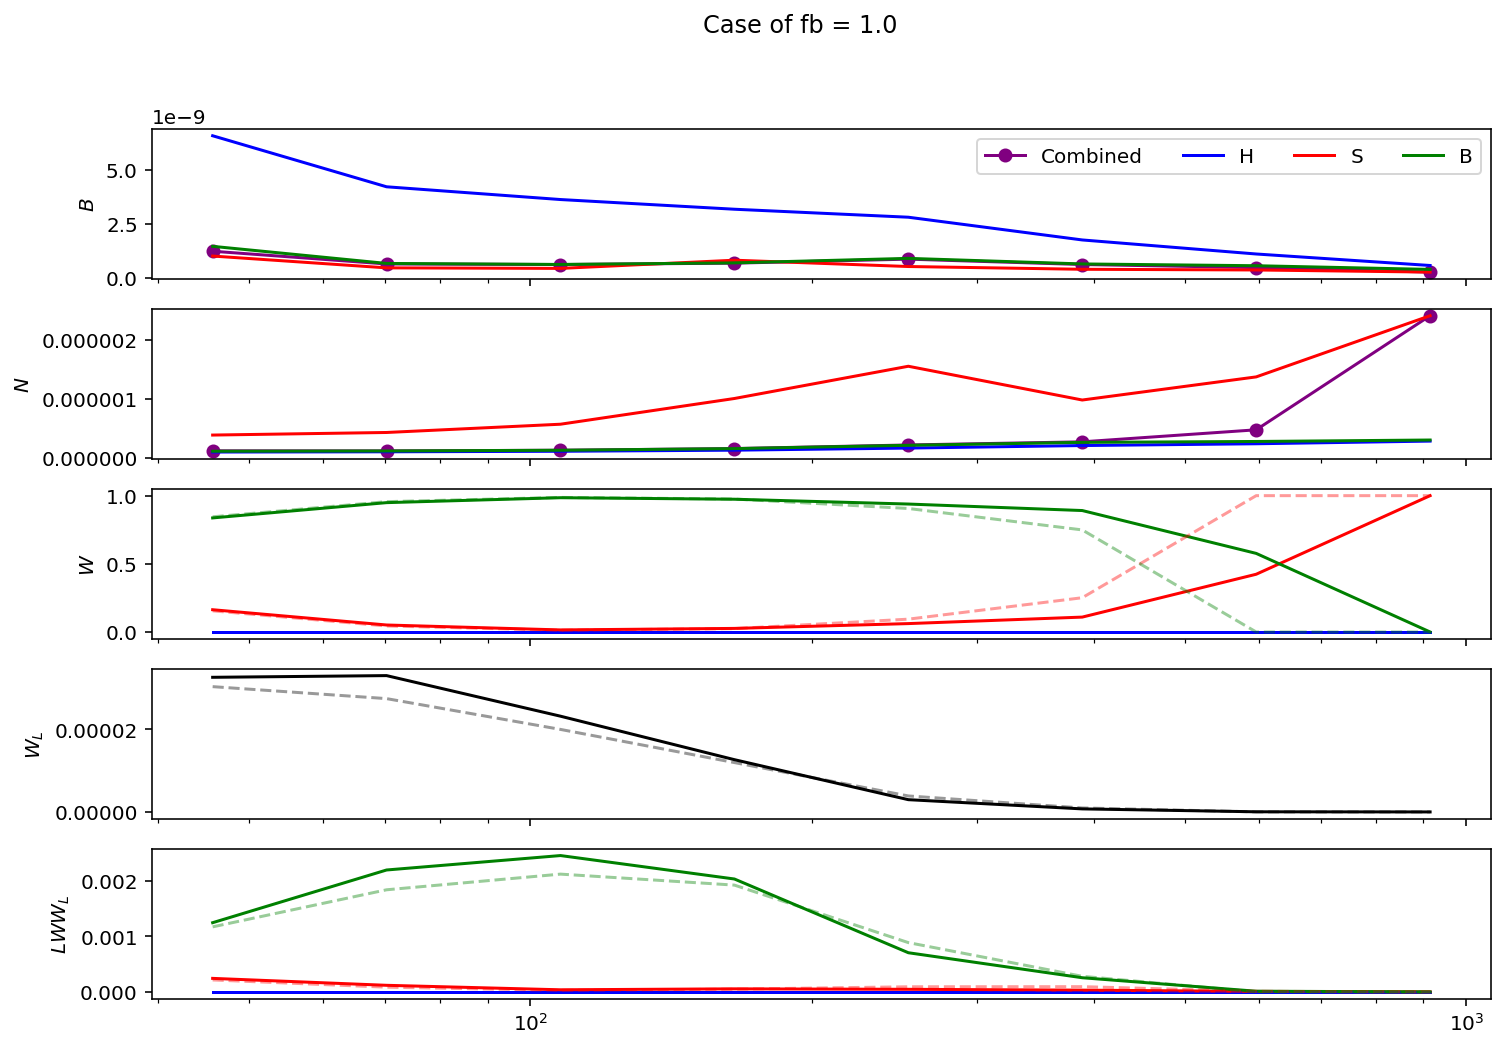

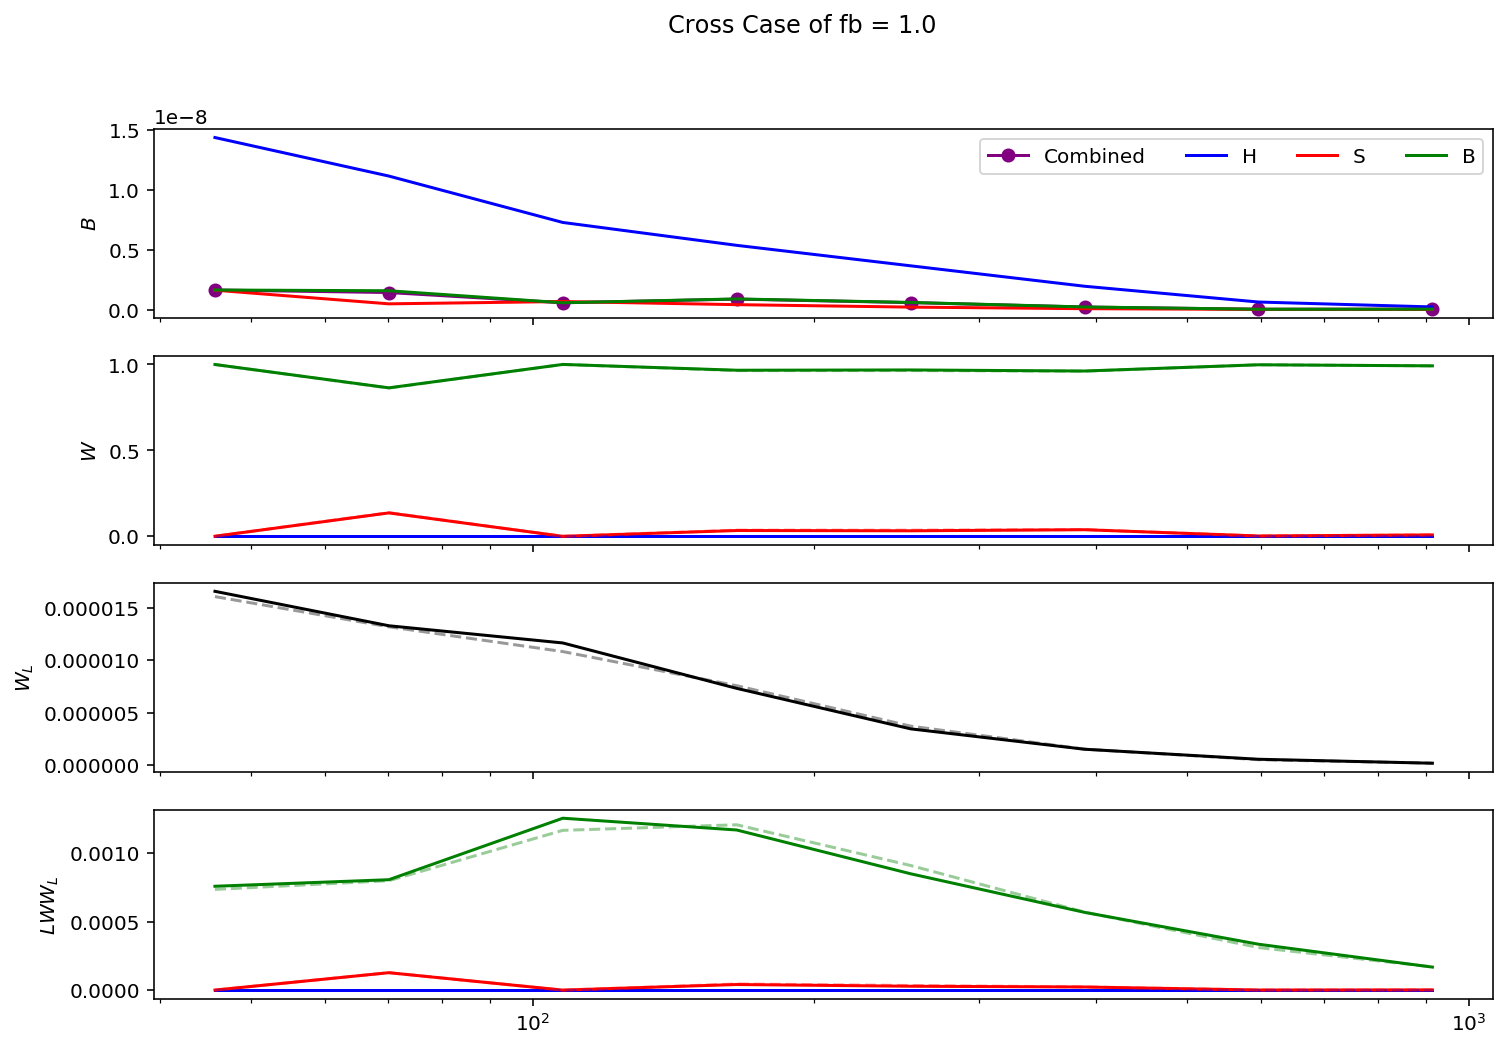

In [504]:
#directory = min(autos, key = autos.get)
all_maxes = ['h2500s2000b2500']
plot_fixed(fb, all_maxes)

In [506]:
selection = df_auto['Detectable Mv Auto'] == False
df_auto[selection].sort_values('Total Mv Auto', ascending = False)

Name  Total Auto  Total Mv Auto  Bias Auto  Noise Auto  \
21   h2000s3500b4500    0.000420       0.000429   0.014185    0.014802   
74   h2000s3500b4000    0.000420       0.000429   0.014185    0.014802   
28   h2000s3000b4500    0.000364       0.000377   0.013051    0.013934   
48   h2000s3000b4000    0.000364       0.000377   0.013060    0.013925   
73   h2000s2000b2000    0.000372       0.000373   0.006474    0.018167   
4    h2500s2000b2000    0.000350       0.000352   0.008433    0.016697   
67   h2000s2500b2000    0.000311       0.000315   0.006996    0.016201   
97   h2500s2500b2000    0.000311       0.000315   0.007419    0.015994   
92   h3500s3500b2500    0.000220       0.000260   0.007994    0.012501   
35   h2500s3500b2500    0.000220       0.000260   0.007994    0.012501   
70   h4500s3500b2500    0.000220       0.000260   0.007994    0.012501   
56   h3000s3500b2500    0.000220       0.000260   0.007994    0.012501   
121  h4000s3500b2500    0.000220       0.000260   0.007994    0.012501   
5    h3000s4500b2500    0.000220       0.000260   0.007994    0.012501   
47   h2500s4500b2500    0.000220       0.000260   0.007994    0.012501   
102  h4500s4500b2500    0.000220       0.000260   0.007994    0.012501   
106  h3500s4500b2500    0.000220       0.000260   0.007994    0.012501   
40   h4000s4500b2500    0.000220       0.000260   0.007994    0.012501   
104  h3000s4000b2500    0.000220       0.000260   0.008003    0.012495   
103  h4000s4000b2500    0.000220       0.000260   0.008003    0.012495   
27   h2500s4000b2500    0.000220       0.000260   0.008003    0.012495   
38   h3500s4000b2500    0.000220       0.000260   0.008003    0.012495   
119  h4500s4000b2500    0.000220       0.000260   0.008003    0.012495   
86   h2500s2500b2500    0.000220       0.000238   0.007966    0.012499   
64   h2000s3500b2500    0.000220       0.000234   0.008071    0.012440   
113  h2000s4500b2500    0.000220       0.000234   0.008071    0.012440   
22   h2000s4000b2500    0.000220       0.000234   0.008076    0.012436   
46   h2000s2500b2500    0.000219       0.000234   0.008028    0.012447   
57   h2000s3000b2500    0.000219       0.000233   0.008163    0.012336   
29   h2000s2000b2500    0.000218       0.000226   0.007847    0.012493   
44   h2500s2000b2500    0.000218       0.000226   0.007827    0.012507   

     Detectable Auto  Bias Mv Auto  Noise Mv Auto  Detectable Mv Auto  \
21             False      0.014637       0.014664               False   
74             False      0.014637       0.014664               False   
28             False      0.013694       0.013778               False   
48             False      0.013694       0.013778               False   
73             False      0.006581       0.018163               False   
4              False      0.008424       0.016777               False   
67             False      0.007147       0.016250               False   
97             False      0.007467       0.016088               False   
92             False      0.011374       0.011431               False   
35             False      0.011374       0.011431               False   
70             False      0.011374       0.011431               False   
56             False      0.011374       0.011431               False   
121            False      0.011374       0.011431               False   
5              False      0.011377       0.011429               False   
47             False      0.011377       0.011429               False   
102            False      0.011377       0.011429               False   
106            False      0.011377       0.011429               False   
40             False      0.011377       0.011429               False   
104            False      0.011393       0.011409               False   
103            False      0.011393       0.011409               False   
27             False      0.011393       0.011409               False   
38             False      0.011393       

h4000s4500b4500


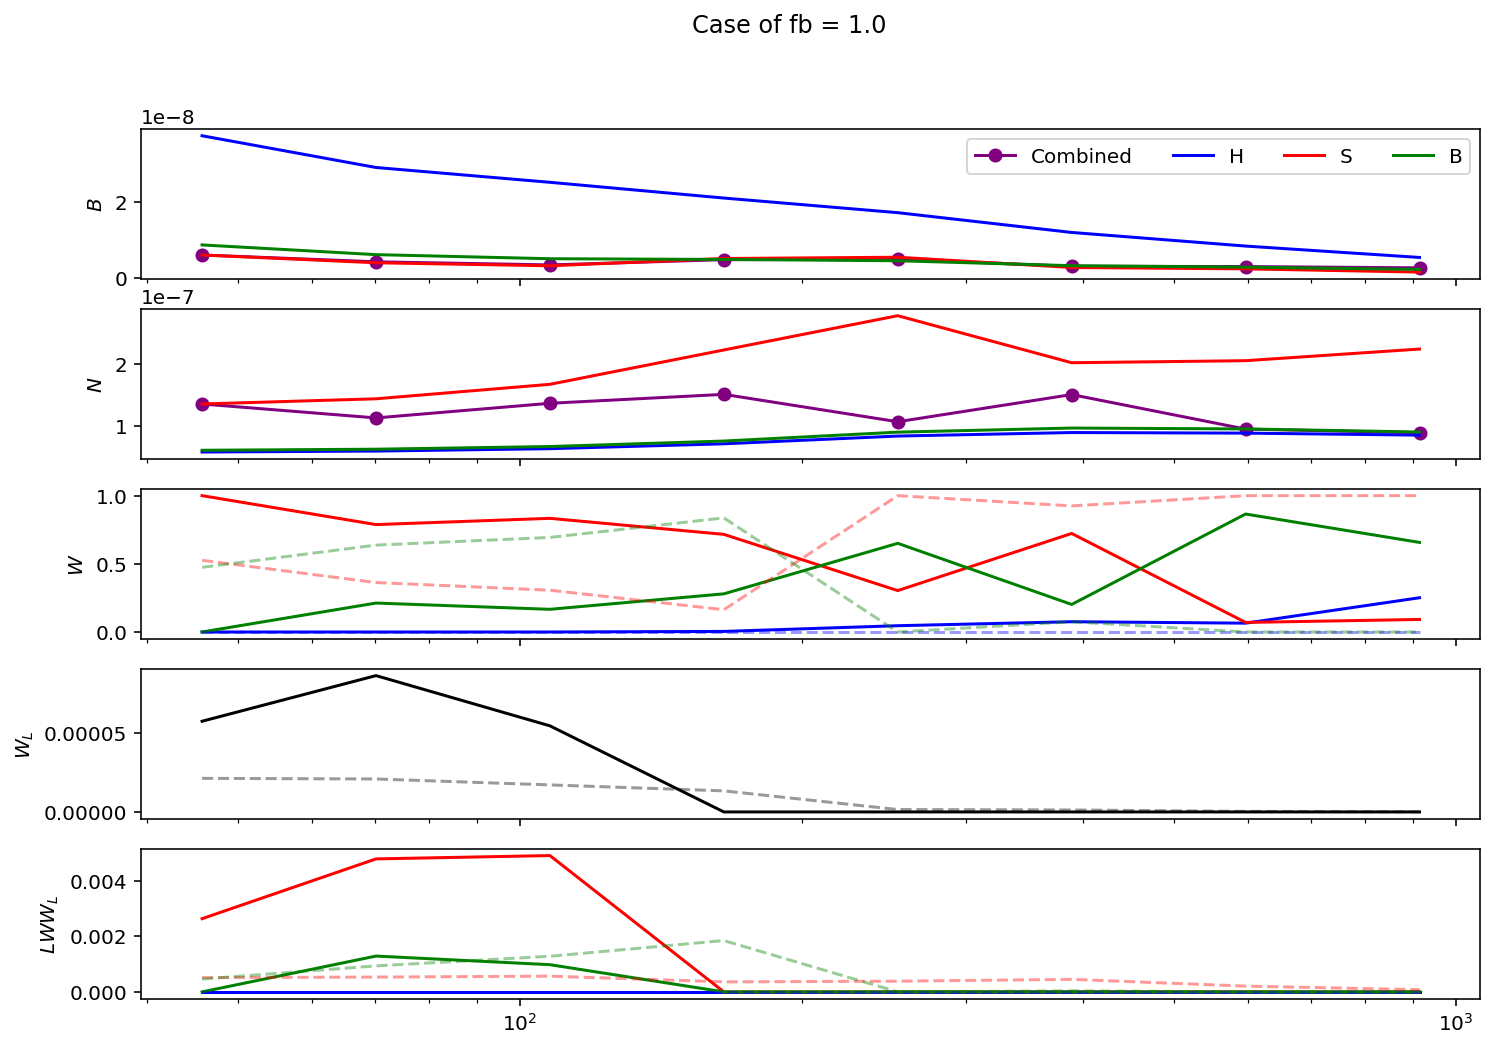

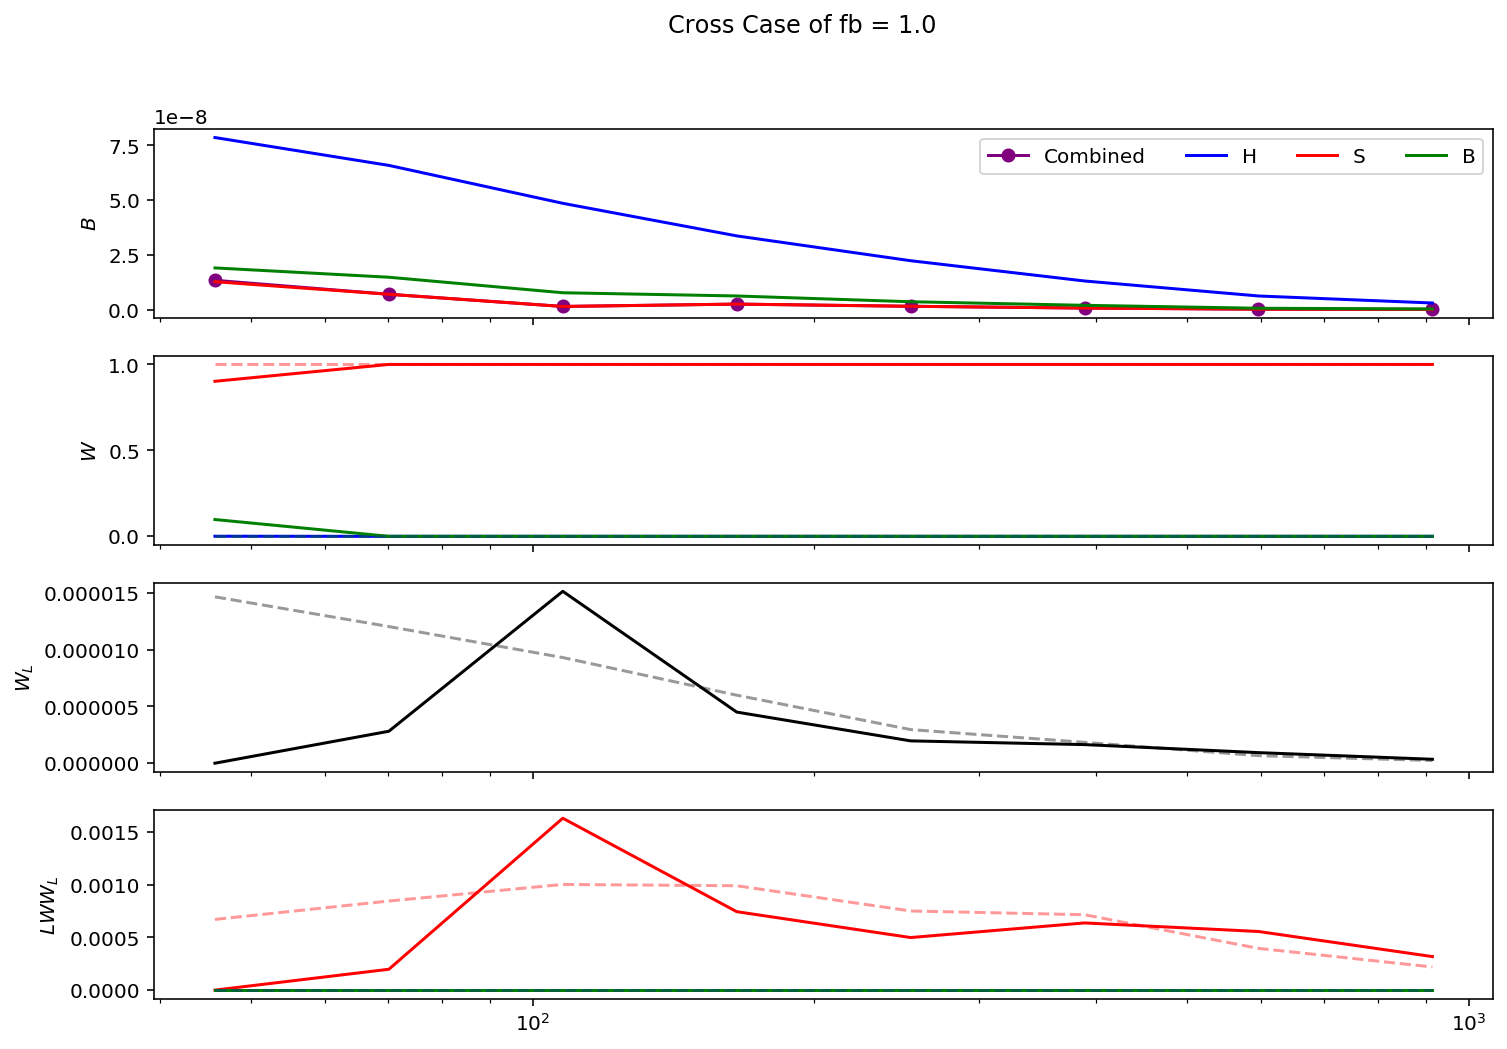

In [492]:
all_maxes = ['h4000s4500b4500']
plot_fixed(fb, all_maxes)

In [486]:
df_cross

Name  Total Cross  Total Mv Cross  Bias Cross  Noise Cross  \
0    h3500s3500b4500     0.000154        0.000163    0.008800     0.008753   
1    h4500s4000b4000     0.000170        0.000183    0.009677     0.008725   
2    h3500s4000b3000     0.000094        0.000098    0.006264     0.007401   
3    h4000s4000b3500     0.000142        0.000154    0.008856     0.008001   
4    h2500s2000b2000     0.000116        0.000117    0.003098     0.010326   
..               ...          ...             ...         ...          ...   
123  h4000s4500b3000     0.000094        0.000098    0.006337     0.007345   
124  h2500s4000b4500     0.000169        0.000182    0.009662     0.008727   
125  h4500s3500b3000     0.000090        0.000091    0.006136     0.007215   
126  h3500s4000b3500     0.000142        0.000154    0.008856     0.008001   
127  h3000s3000b2500     0.000077        0.000077    0.003482     0.008025   

     Detectable Cross  Bias relative to H  Noise relative to H    Bias H  \
0                True            0.074624             1.454384  0.117922   
1                True            0.049800             1.484257  0.194314   
2               False            0.053119             1.229822  0.117922   
3                True            0.052288             1.357030  0.169368   
4               False            0.127266             1.336308  0.024342   
..                ...                 ...                  ...       ...   
123             False            0.037417             1.245823  0.169368   
124              True            0.396912             1.129341  0.024342   
125             False            0.031576             1.227264  0.194314   
126              True            0.075100             1.329399  0.117922   
127             False            0.055846             1.235087  0.062341   

      Noise H    Bias S   Noise S   Bias BH  Noise BH  
0    0.006018  0.009666  0.008318  0.024899  0.006020  
1    0.005879  0.010798  0.008125  0.018893  0.006119  
2    0.006018  0.010798  0.008125  0.007442  0.006937  
3    0.005896  0.010798  0.008125  0.013089  0.006334  
4    0.007727  0.001770  0.015680  0.001336  0.011008  
..        ...       ...       ...       ...       ...  
123  0.005896  0.009535  0.008097  0.007442  0.006937  
124  0.007727  0.010798  0.008125  0.024899  0.006020  
125  0.005879  0.009666  0.008318  0.007442  0.006937  
126  0.006018  0.010798  0.008125  0.013089  0.006334  
127  0.006498  0.007350  0.009061  0.003455  0.008241  

[128 rows x 14 columns]

In [487]:
df_cross.sort_values('Total Mv Cross')

Name  Total Cross  Total Mv Cross  Bias Cross  Noise Cross  \
127  h3000s3000b2500     0.000077        0.000077    0.003482     0.008025   
39   h3500s3000b2500     0.000077        0.000077    0.003482     0.008025   
32   h4500s3000b2500     0.000077        0.000077    0.003482     0.008025   
54   h4000s3000b2500     0.000077        0.000077    0.003482     0.008025   
57   h2000s3000b2500     0.000077        0.000077    0.003482     0.008025   
..               ...          ...             ...         ...          ...   
1    h4500s4000b4000     0.000170        0.000183    0.009677     0.008725   
78   h3000s4000b4500     0.000170        0.000183    0.009642     0.008764   
90   h3000s4000b4000     0.000170        0.000183    0.009677     0.008725   
112  h3500s4000b4500     0.000170        0.000183    0.009642     0.008764   
18   h3500s4000b4000     0.000170        0.000183    0.009677     0.008725   

     Detectable Cross  Bias relative to H  Noise relative to H    Bias H  \
127             False            0.055846             1.235087  0.062341   
39              False            0.029524             1.333457  0.117922   
32              False            0.017917             1.365155  0.194314   
54              False            0.020556             1.361172  0.169368   
57              False            0.372121             0.778598  0.009356   
..                ...                 ...                  ...       ...   
1                True            0.049800             1.484257  0.194314   
78               True            0.154672             1.348829  0.062341   
90               True            0.155224             1.342841  0.062341   
112              True            0.081769             1.456258  0.117922   
18               True            0.082061             1.449794  0.117922   

      Noise H    Bias S   Noise S   Bias BH  Noise BH  
127  0.006498  0.007350  0.009061  0.003455  0.008241  
39   0.006018  0.007350  0.009061  0.003455  0.008241  
32   0.005879  0.007350  0.009061  0.003455  0.008241  
54   0.005896  0.007350  0.009061  0.003455  0.008241  
57   0.010307  0.007350  0.009061  0.003455  0.008241  
..        ...       ...       ...       ...       ...  
1    0.005879  0.010798  0.008125  0.018893  0.006119  
78   0.006498  0.010798  0.008125  0.024899  0.006020  
90   0.006498  0.010798  0.008125  0.018893  0.006119  
112  0.006018  0.010798  0.008125  0.024899  0.006020  
18   0.006018  0.010798  0.008125  0.018893  0.006119  

[128 rows x 14 columns]

In [488]:
directory = min(crosses, key = crosses.get)
all_maxes = [directory]
plot_fixed(fb, all_maxes)

h2000s3000b2500


**Simple check**

In [163]:
lmax = 3500

In [164]:
fbs = [0., 1., 5., 10., 100.]
noisebiasconstr = False


In [173]:
totals_auto = []
totals_cross = []

noises_auto = []
noises_cross = []

biases_auto = []
biases_cross = []

h3500s3500b3500
0.0
Total auto 4.0284533636240335e-05
Total cross 3.622042315447236e-05
Total auto 4.0284533636237625e-05
Total cross 3.6220423154471514e-05


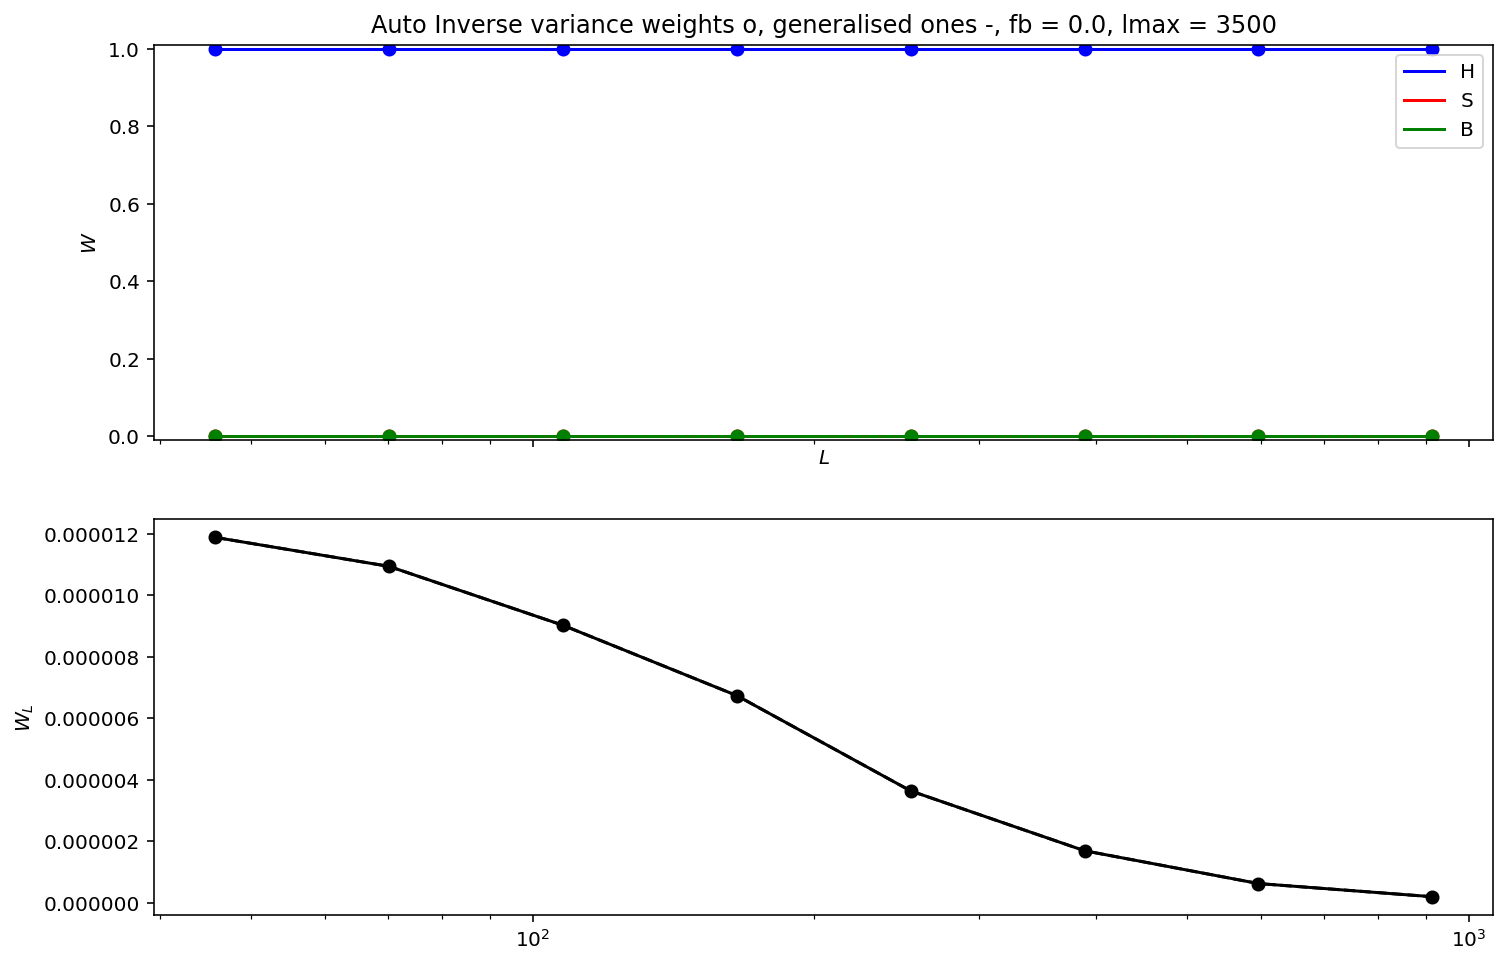

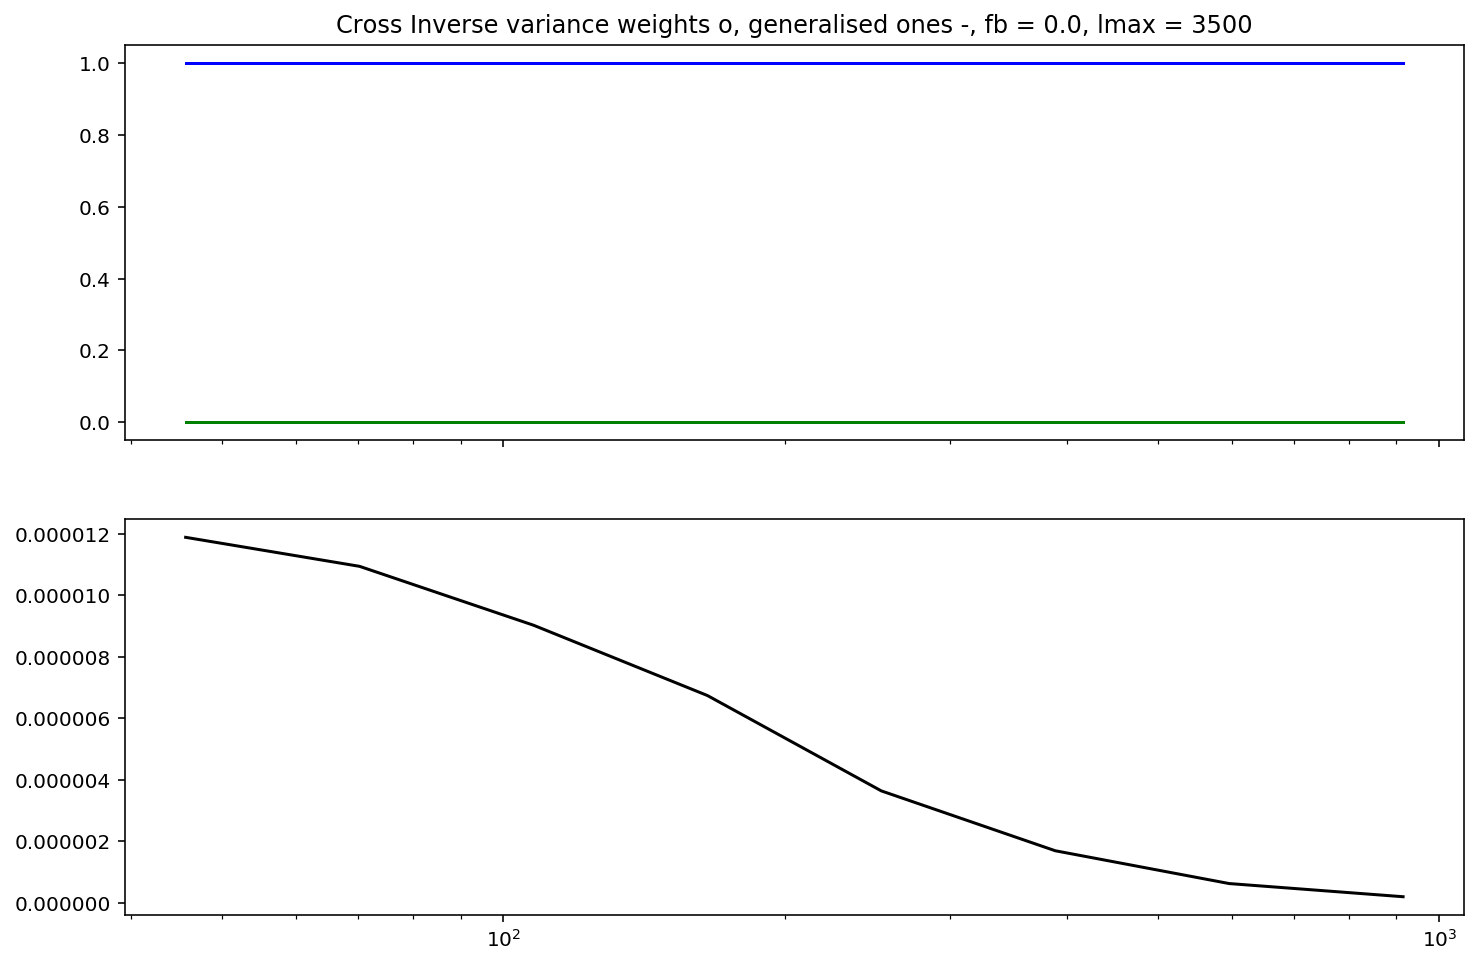

h3500s3500b3500
1.0
Total auto 0.016751710788213324
Total cross 0.013219531761798556
Total auto 0.038638635972422036
Total cross 0.009264855911656749


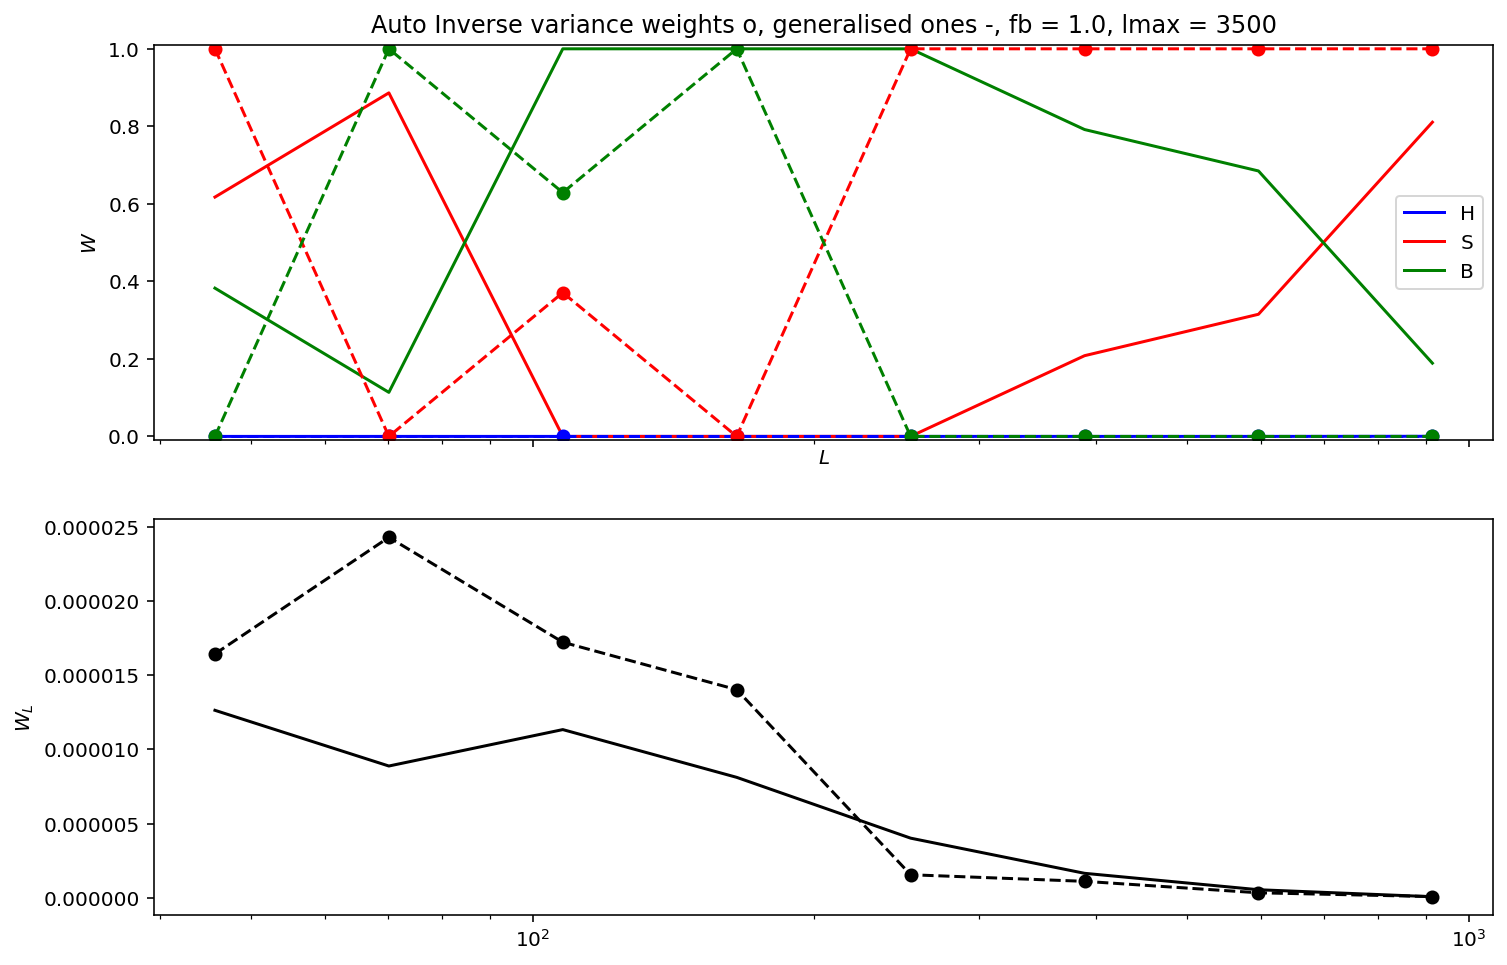

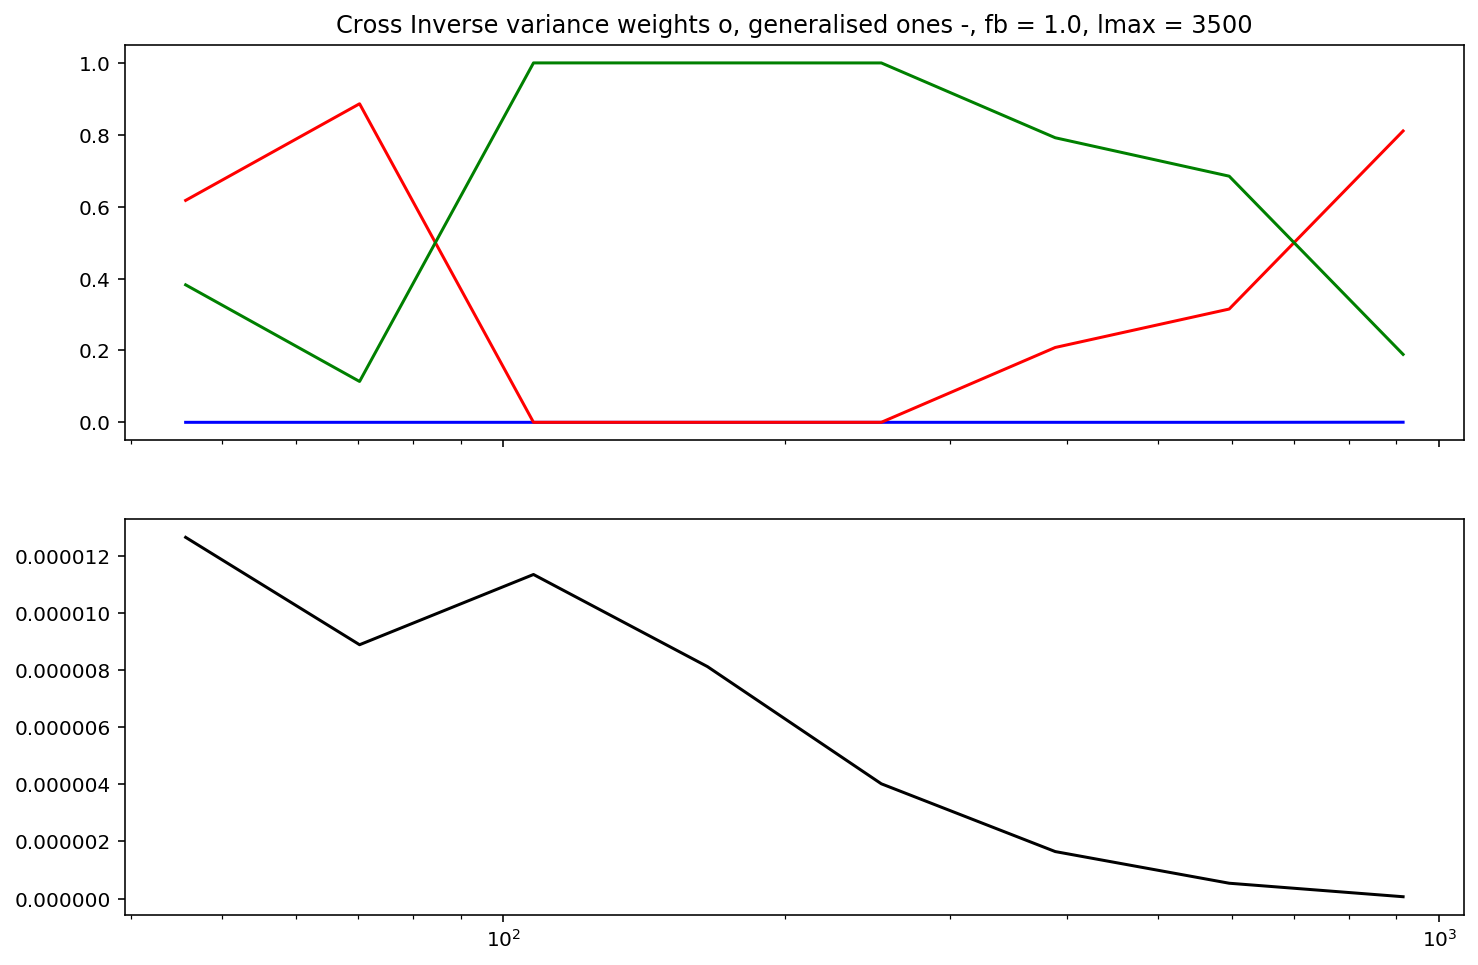

h3500s3500b3500
5.0
Total auto -0.014937550854250187
Total cross 0.002065417195948446
Total auto 0.18322039102824142
Total cross 0.04611235501653909


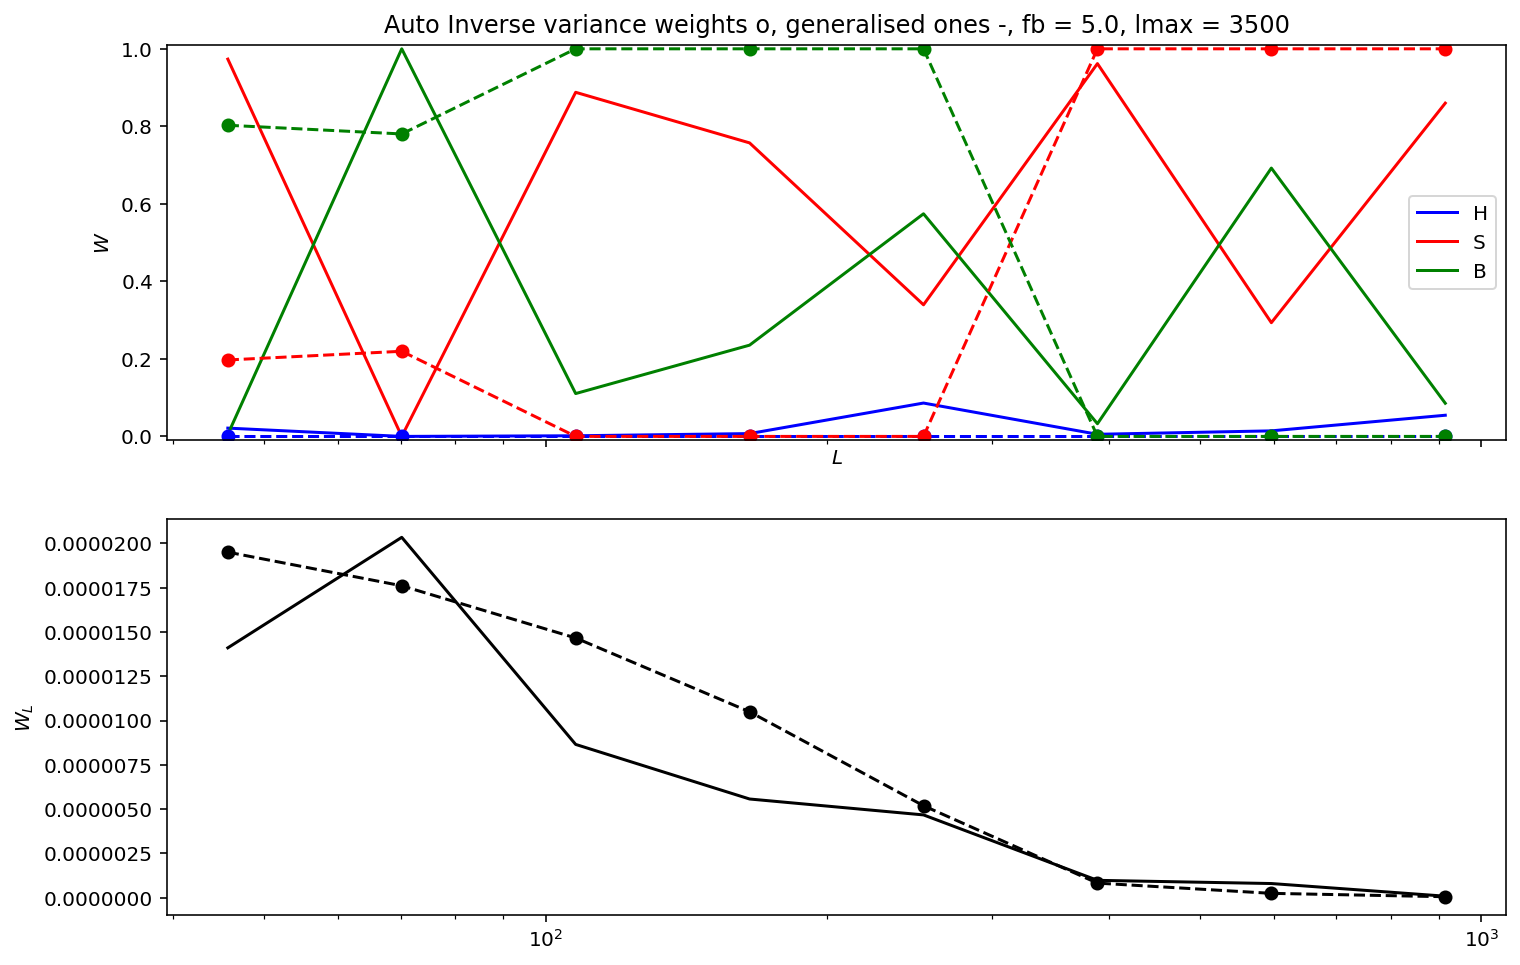

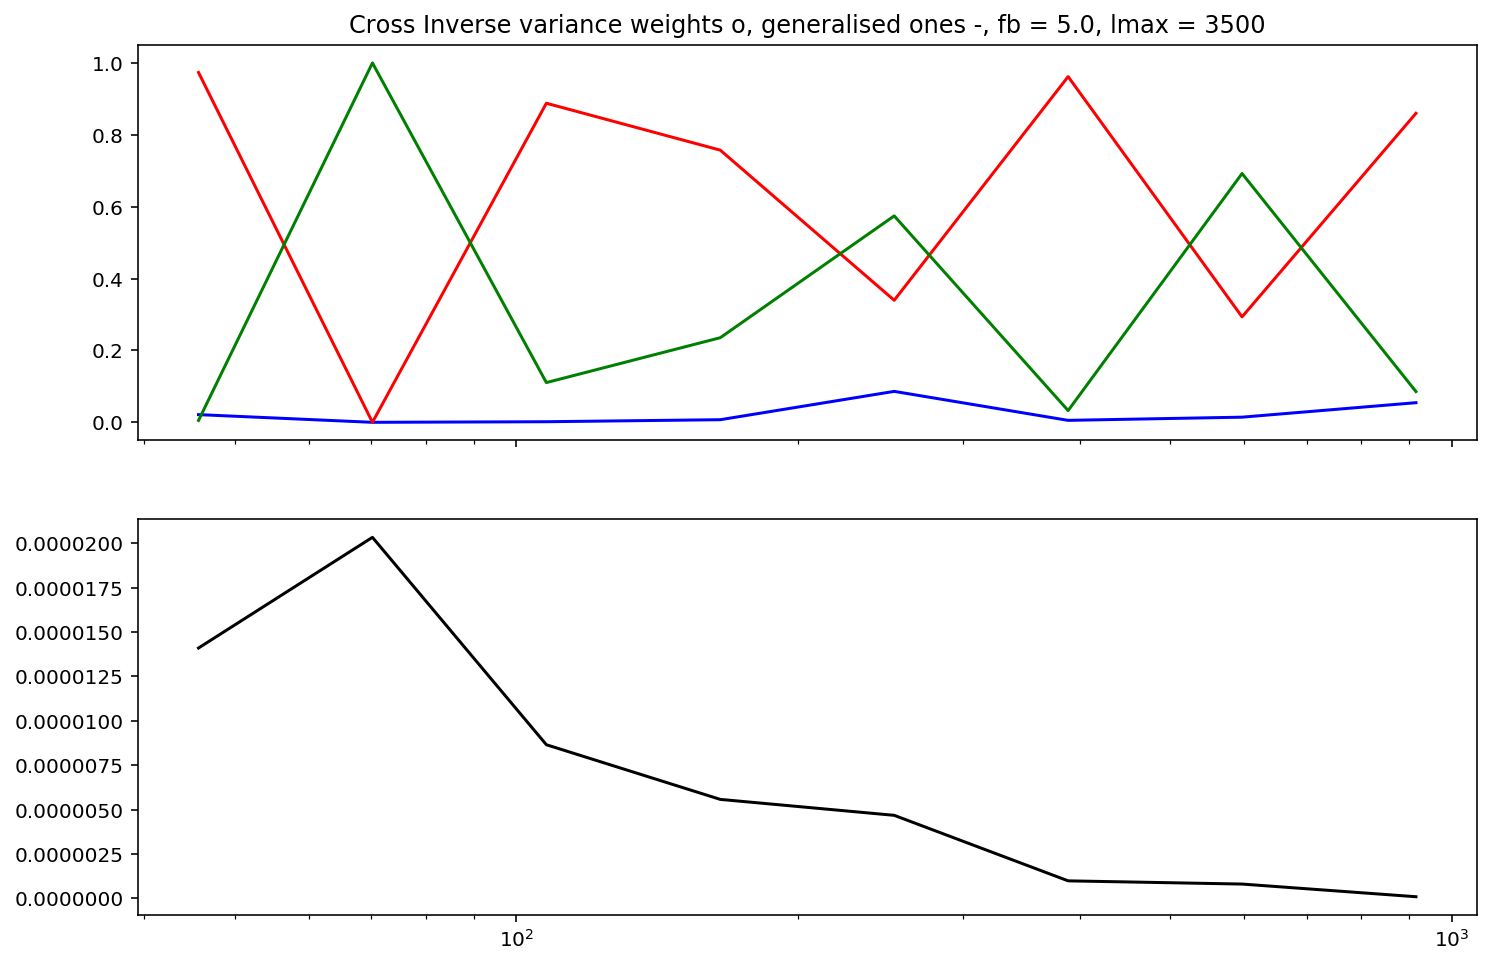

h3500s3500b3500
10.0
Total auto -0.030780507726373526
Total cross -0.0006900720080994776
Total auto 0.3858861846283224
Total cross 0.09207114580221479


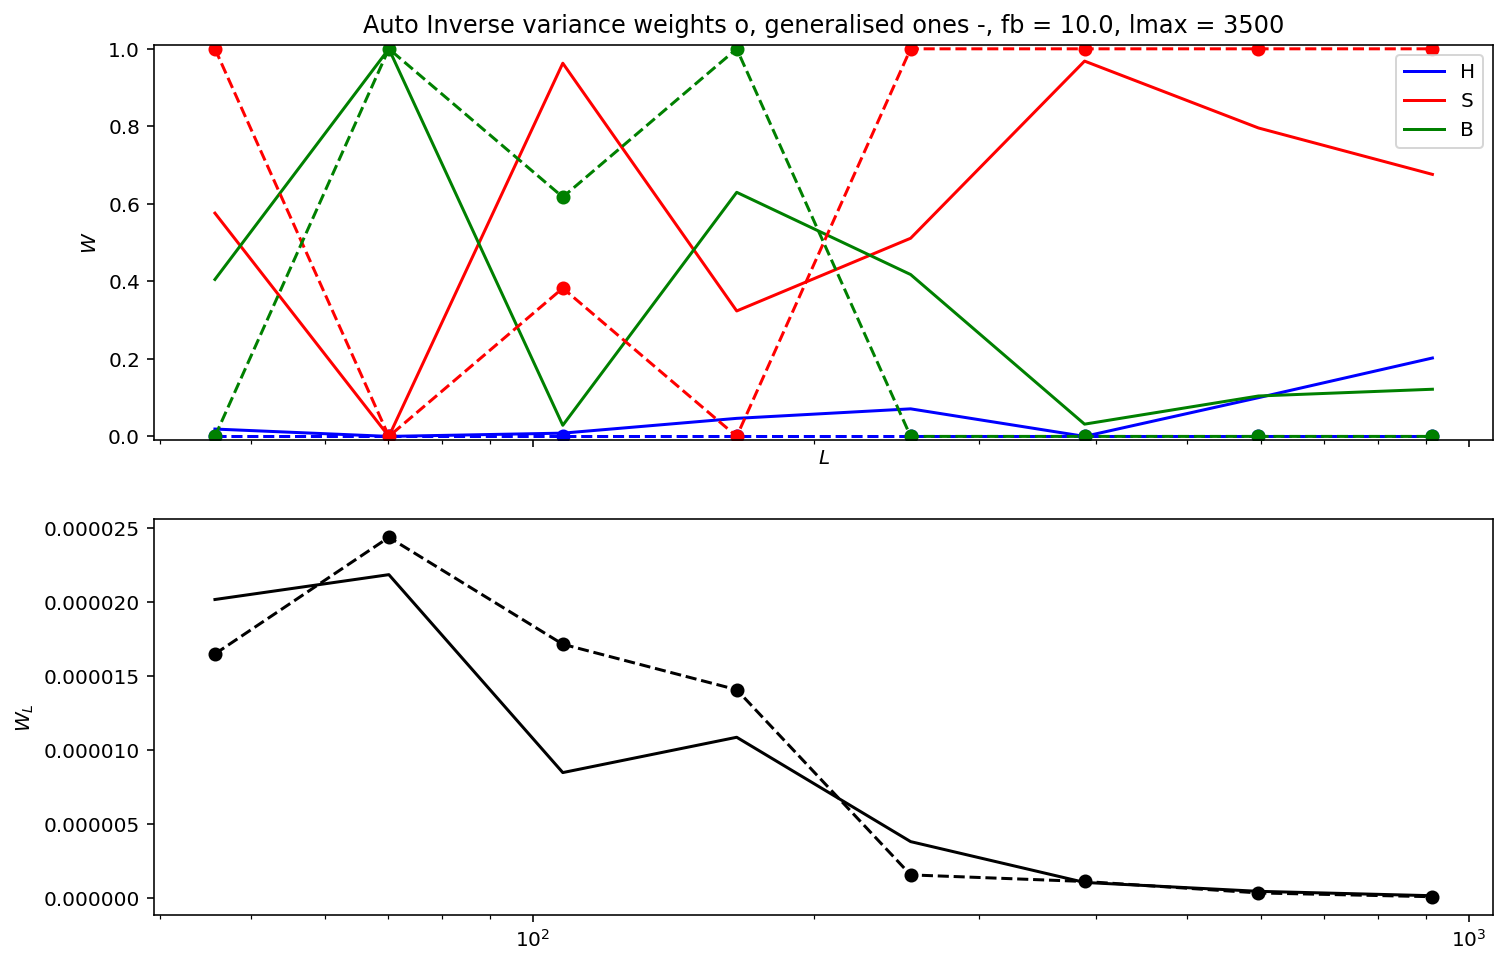

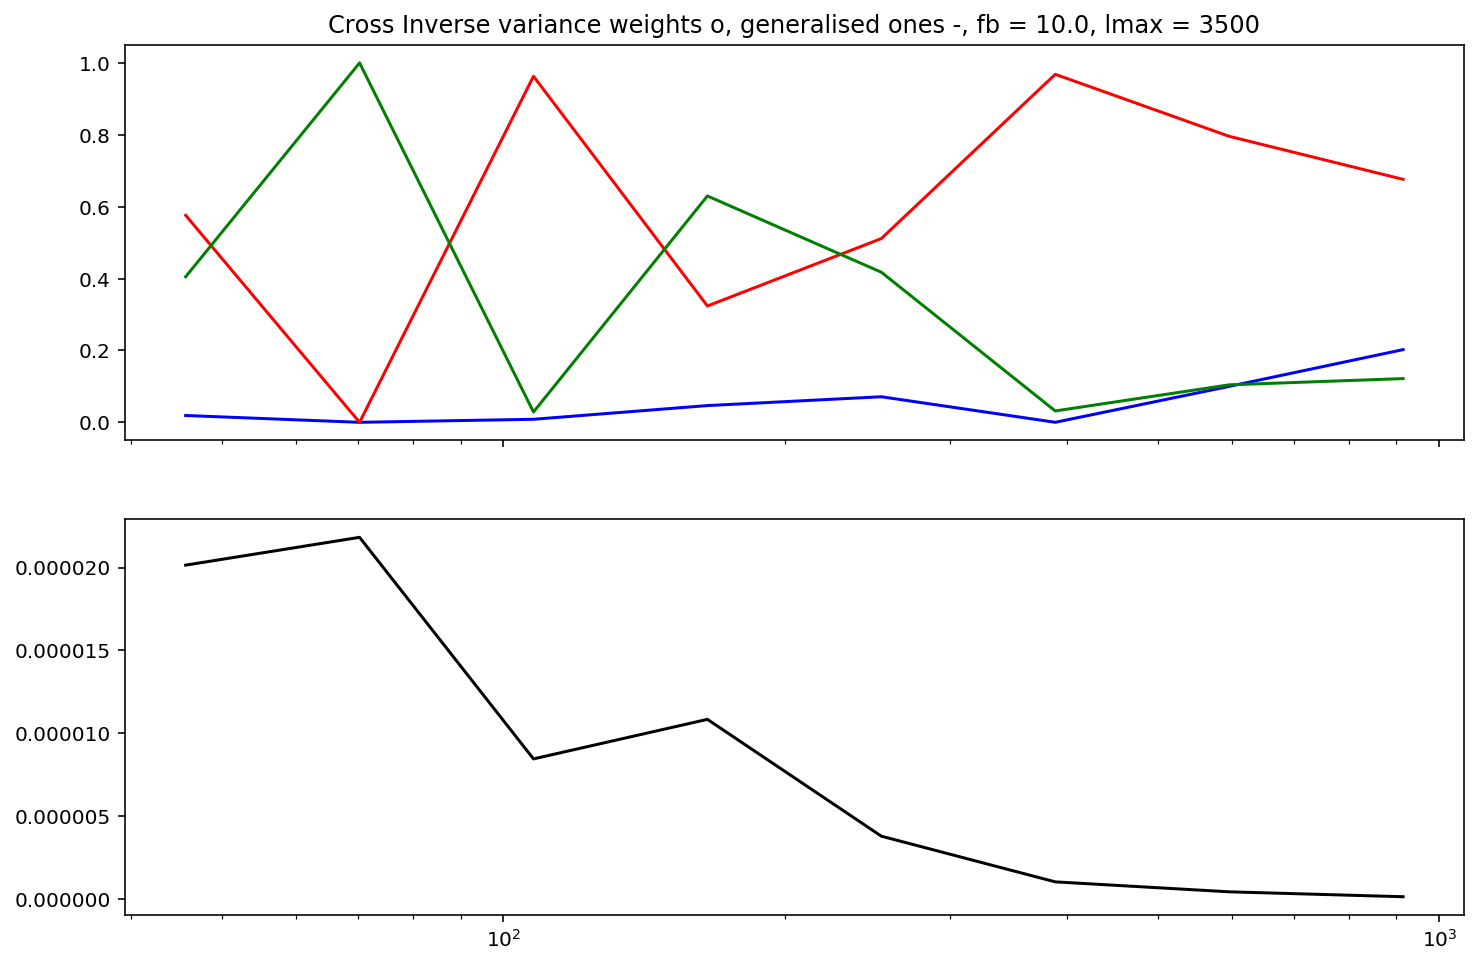

h3500s3500b3500
100.0
Total auto 2.2380571975896824
Total cross 1.8872032915305776
Total auto 3.6630488313781764
Total cross 0.9211900845805014


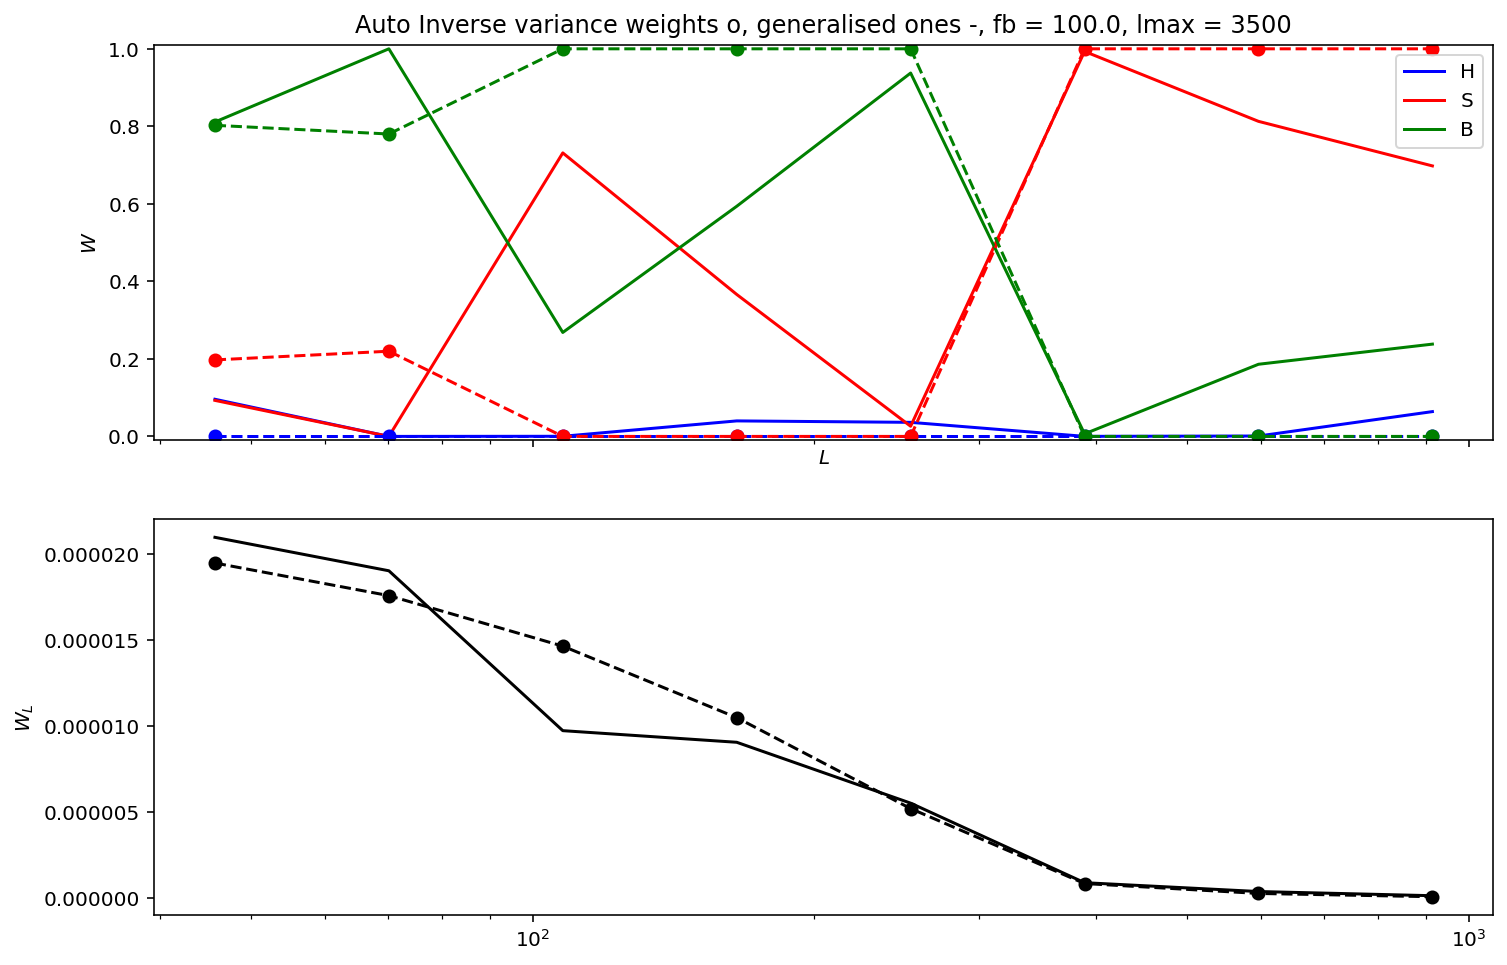

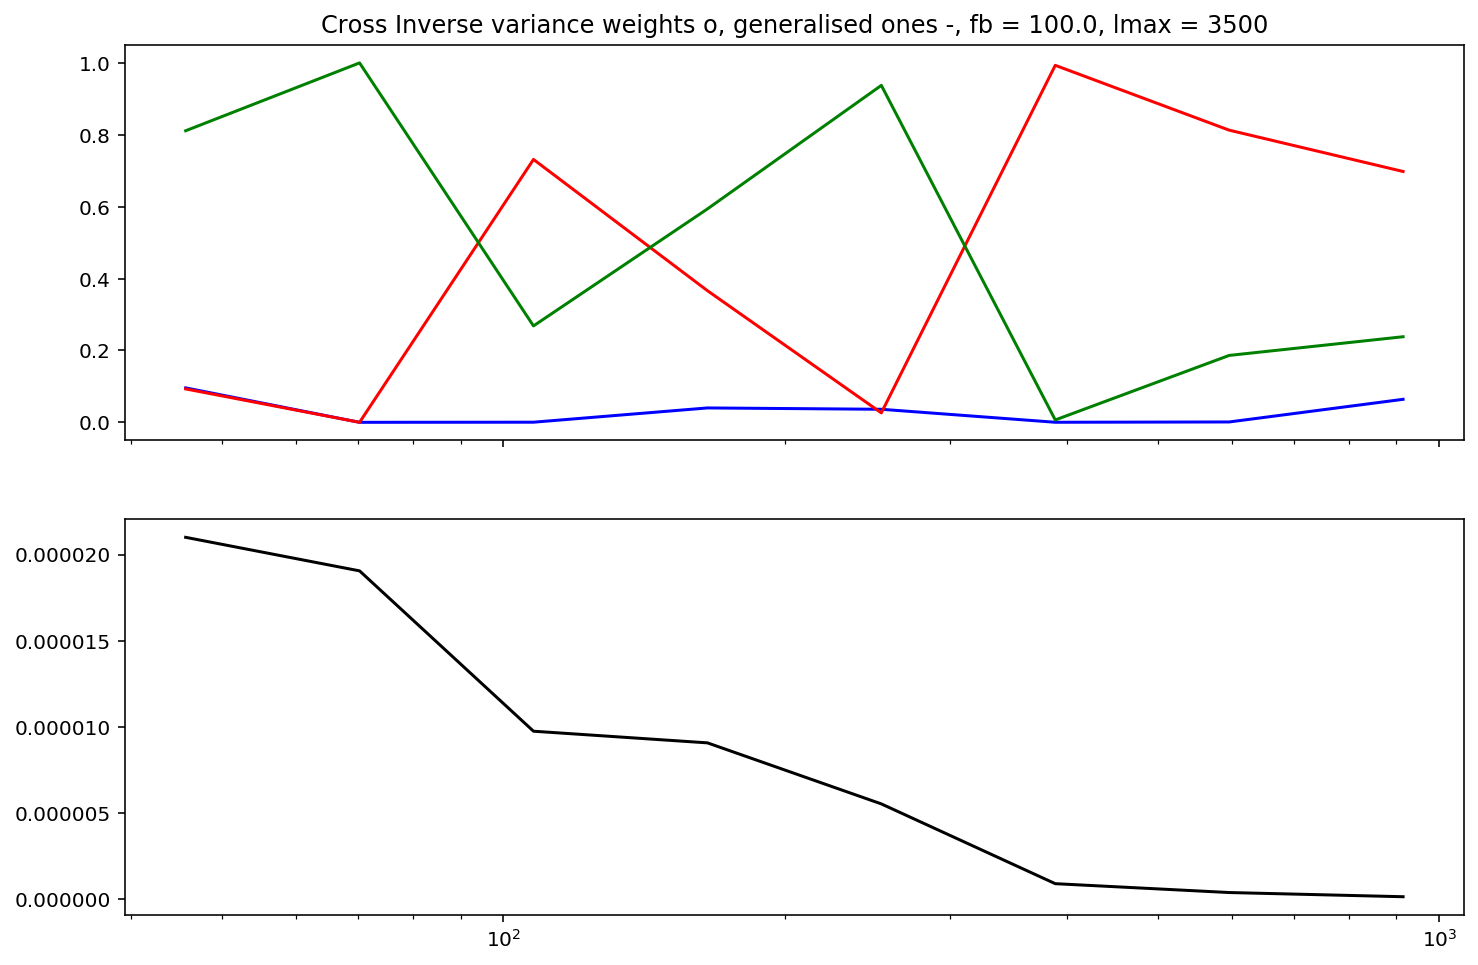

In [174]:
for fb in fbs:
    fig, ax = plt.subplots(nrows = 2, sharex = True)
    ax[0].set_title(f'Auto Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    fig2, ax2 = plt.subplots(nrows = 2, sharex = True)

    ax2[0].set_title(f'Cross Inverse variance weights o, generalised ones -, fb = {fb}, lmax = {lmax}')
    
    for fgnamefile in [fgnamefiles[0]]:
        lmax_directory = f'h{lmax}s{lmax}b{lmax}'
        
        print(lmax_directory)

        invvariance = False


        print(fb)
        
        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auto, cross = get_total(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        auton, crossn = get_noise(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        autob, crossb = get_bias(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)
        
        totals_auto += [auto]
        totals_cross += [cross]
        
        noises_auto += [auton]
        noises_cross += [crossn]
        
        biases_auto += [autob]
        biases_cross += [crossb]
        
        
        

        
        ax[0].plot(ells, w1, color = 'blue', label = 'H')
        ax[0].plot(ells, w2, color = 'red', label = 'S')
        ax[0].plot(ells, w3, color = 'green', label = 'B')

        ax[1].plot(ells, wl, color = 'black')
        
        ax2[0].plot(ells, w1, color = 'blue', label = 'H')
        ax2[0].plot(ells, w2, color = 'red', label = 'S')
        ax2[0].plot(ells, w3, color = 'green', label = 'B')

        ax2[1].plot(ells, wl, color = 'black')

        invvariance = True

        ells, w1, w2, w3, wl, w1c, w2c, w3c, wlc =  w_get_dict_results(nu, noisetag, analysis_directory, estimators, lmin_sel, lmax_sel, noisebiasconstr, invvariance,
                     fgnamefile, lmax_directory, fb)

        ax[0].plot(ells, w1, color = 'blue', ls = '--', marker = 'o')
        ax[0].plot(ells, w2, color = 'red', ls = '--', marker = 'o')
        ax[0].plot(ells, w3, color = 'green', ls = '--', marker = 'o')

        ax[1].plot(ells, wl, color = 'black', ls = '--', marker = 'o')




    ax[0].set_ylabel('$W$')
    ax[1].set_ylabel('$W_L$')
    ax[0].set_xlabel('$L$')
    ax[0].set_yscale('linear')
    ax[0].set_ylim(-0.01, 1.01)
    ax[-1].set_xscale('log')
    
    ax2[-1].set_xscale('log')

    ax[0].legend()
    plt.show()

Text(0, 0.5, 'Total')

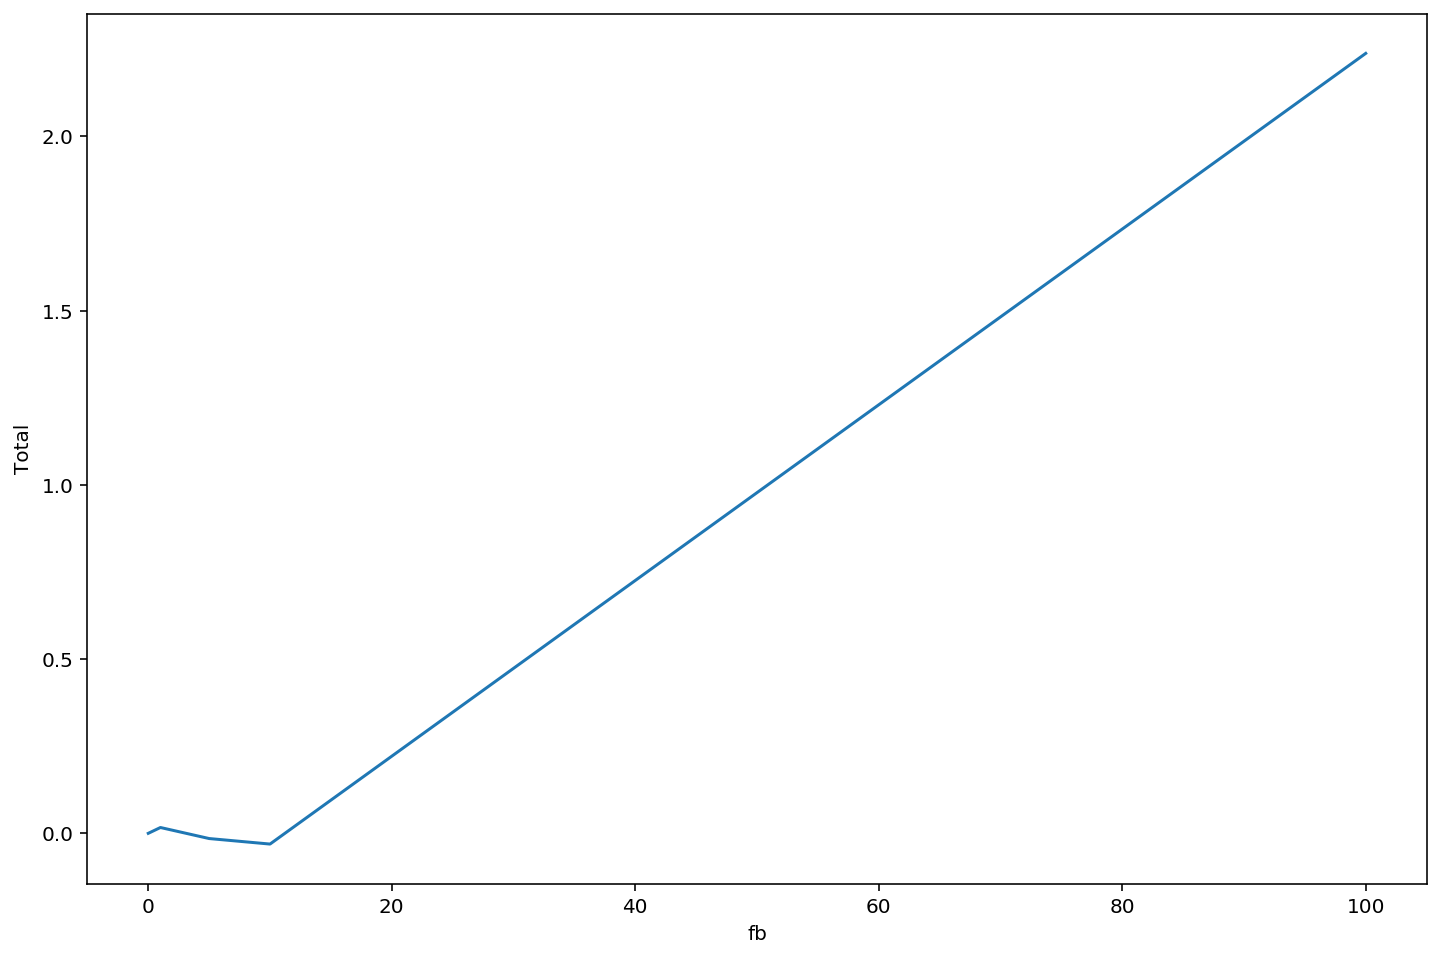

In [170]:
plt.plot(fbs, totals_auto)
plt.xlabel('fb')
plt.ylabel('Total')

Text(0, 0.5, 'Noise')

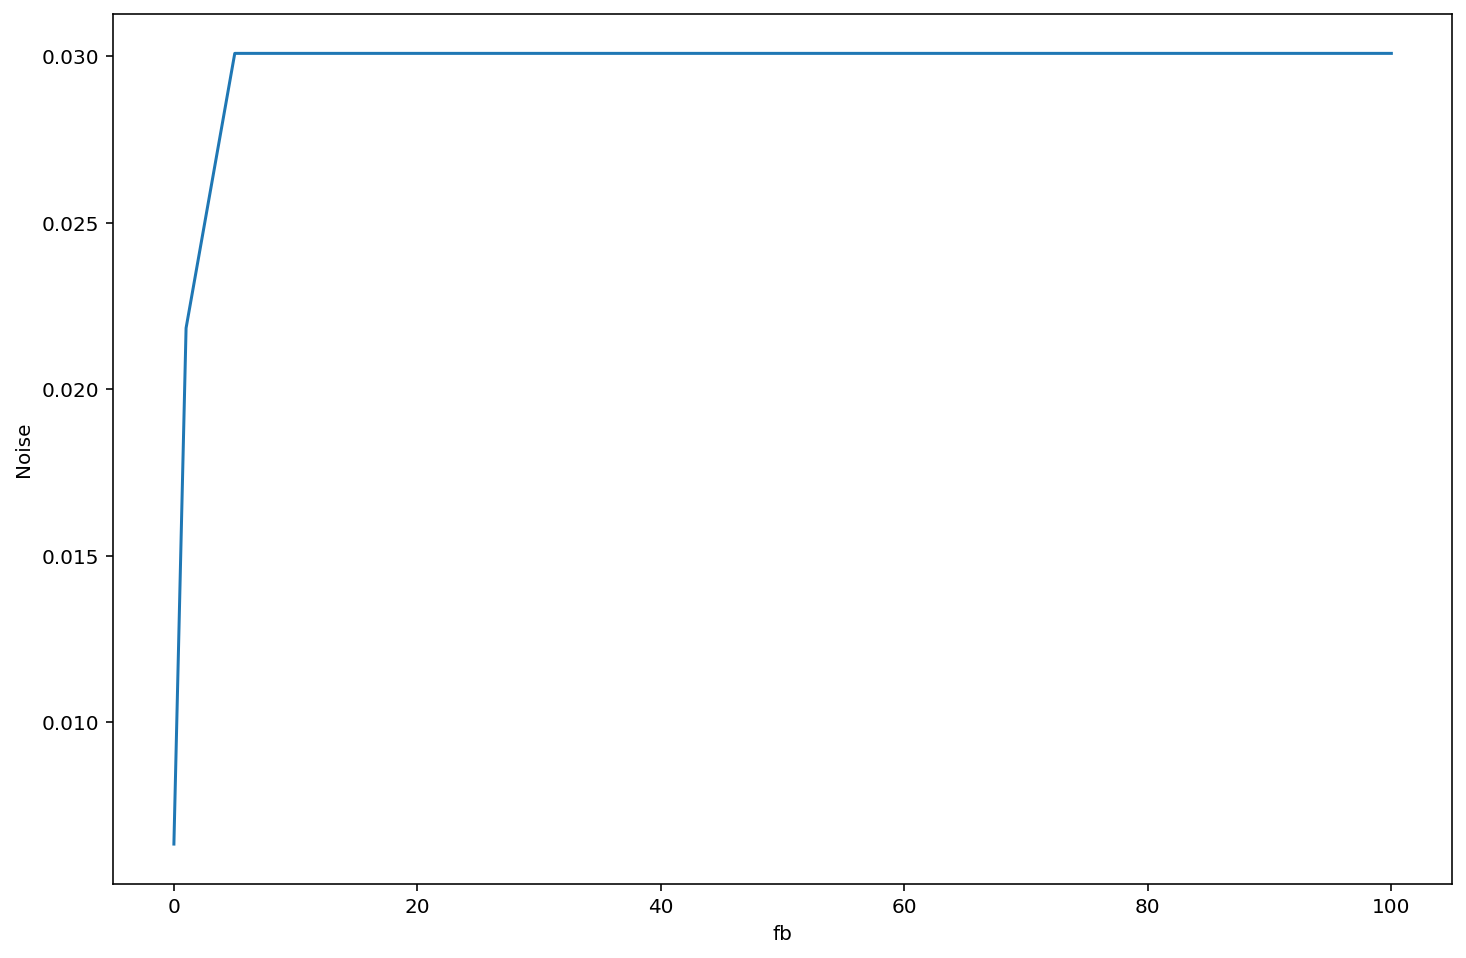

In [175]:
plt.plot(fbs, noises_auto)
plt.xlabel('fb')
plt.ylabel('Noise')

Text(0, 0.5, 'Bias')

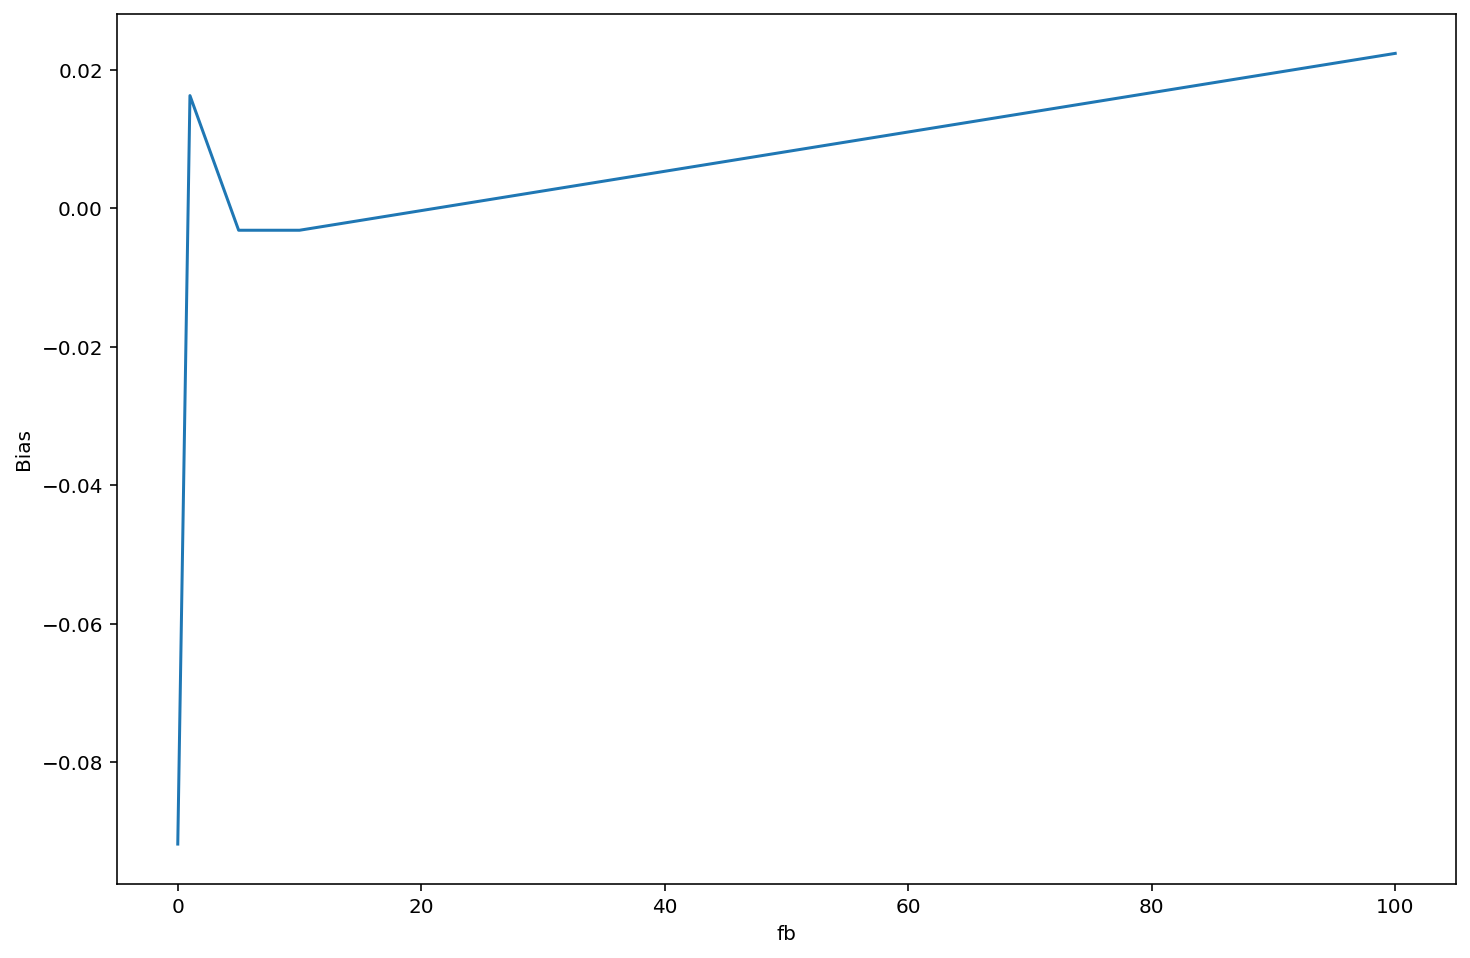

In [177]:
plt.plot(fbs, biases_auto)
plt.xlabel('fb')
plt.ylabel('Bias')

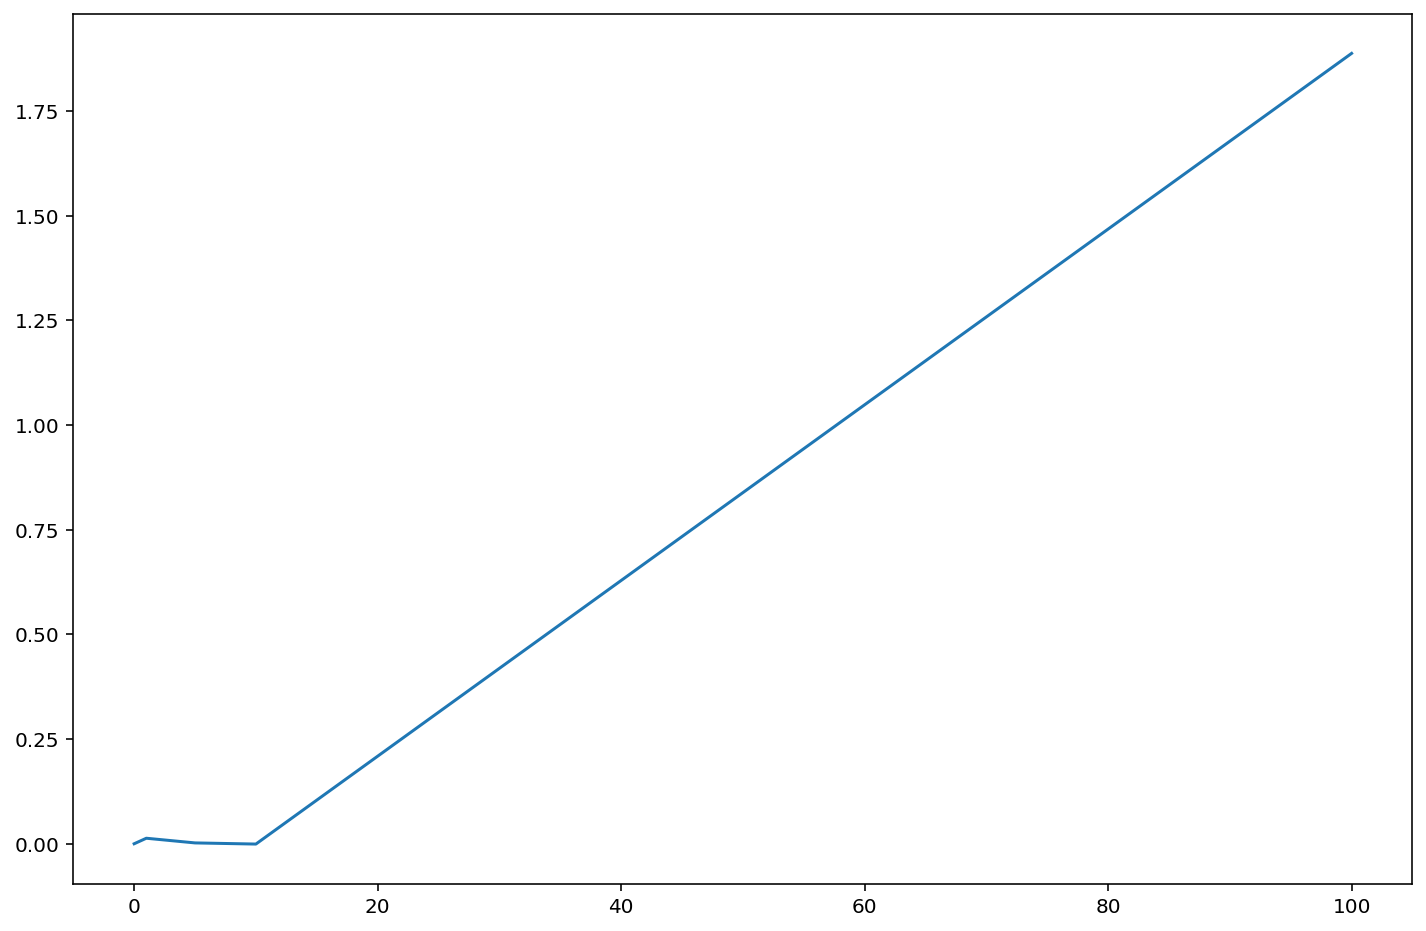

In [171]:
plt.plot(fbs, totals_cross)

In [107]:
min(autos, key = autos.get)

'h4000s4500b4000'

In [110]:
autos['h4000s4500b4000']

-0.007031717557891617

In [111]:
autos['h2000s2000b2000']

-0.0003286623674444945

In [47]:
bh = 3500

In [122]:
results = pathlib.Path('results/')

In [52]:
Res = best.Res(0, 0)

In [101]:
get_directory_lmax = lambda h, s, b: f'h{h}s{s}b{b}'

In [56]:
matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'inversevariance/w_auto_fb_1.0.npy')
ells = matrix[0, :]
w1, w2, w3, w = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

matrix = np.load(results/get_directory_lmax(2500, 2500, 2500)/'w_cross_fb_1.0.npy')
w1c, w2c, w3c, wc = matrix[1, :], matrix[2, :], matrix[3, :], matrix[4, :]

NameError: name 'results' is not defined

In [57]:
plt.plot(ells, w1, color = 'blue', label = 'h')
#plt.plot(ells, w1c, color = 'blue', ls = '--')

plt.plot(ells, w2, color = 'red', label = 's')
#plt.plot(ells, w2c, color = 'red', ls = '--')

plt.plot(ells, w3, color = 'green', label = 'b')
#plt.plot(ells, w3c, color = 'green', ls = '--')

plt.legend()

NameError: name 'ells' is not defined

In [58]:
plt.plot(ells, w, color = 'black')
plt.plot(ells, wc, color = 'black', ls = '--')

NameError: name 'ells' is not defined

In [107]:
import re

re.findall(r'\d+', 'h3000s2000b3000')

['3000', '2000', '3000']

In [108]:
P

PosixPath('output/h4500s4500b4500')

In [115]:
path = pathlib.Path('output')
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir()]
len(all_lmaxes_directories)

128